This Jupyter notebook aims to classify bullying tweets using a variety of traditional machine learning and deep learning models, and then compares their performances with each other.

# Table of Contents

- [1 - Data Import & Data Cleaning](#1)
    - [1.1 - Installing & Import libraries](#1.1)
    - [1.1 - Importing Datasets](#1.2)
    - [1.2 - Cleaning](#1.3)
- [2 - Analyzing the dataset](#2)
    - [2.1 - Category-wise Analysis](#2.1)
    - [2.2 - Tweets length Analysis](#2.2)
- [3 - Traditional Models](#3)
    - [3.1 - Random Forest](#3.1)
    - [3.2 - Gradient Boosting](#3.2)
    - [3.3 - Naive Bayes](#3.3)
    - [3.4 - Logistic Regression](#3.4)
    - [3.5 - Stacking](#3.5)
    - [3.6 - KNN](#3.6)

- [4 - Evaluation of all Models](#4)

<a name='1'></a>

# Data Import & Data Cleaning

<a name='1.1'></a>
## Installing & Import libraries

In [111]:
! pip install langdetect
! pip install contractions
! pip install emoji
! pip install imblearn
! pip install torch
! pip install transformers
! pip install demoji
! pip install nltk
! pip install gensim
! pip install plotly

In [113]:
# General purpose
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
import os

# Text cleaning
import re
import string
import emoji
import demoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
# Stop words for text cleaning
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')  # Download the punkt tokenizer
nltk.download('wordnet')  # Download WordNet for lemmatization

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from langdetect import detect, LangDetectException
from sklearn.preprocessing import OneHotEncoder
import contractions
from nltk.tokenize import word_tokenize

# Balancing
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix, roc_curve, auc

# Traditional Machine Learning Models
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC

# PyTorch for Deep Learning models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tensorflow for Deep Learning models
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization

# Tokenization for GRU (word2Vec Embedding)
from collections import Counter
from gensim.models import Word2Vec

# Transformers for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<Figure size 640x480 with 0 Axes>

In [114]:
import nltk

# Specify the directory to download NLTK data
nltk_data_dir = "/kaggle/working/nltk_data"

# Download the necessary NLTK resources to the specified directory
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)

# Set the NLTK data path
nltk.data.path.append(nltk_data_dir)

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [115]:
import os
import zipfile

# Define the paths for the zip files
nltk_data_dir = "/kaggle/working/nltk_data"
corpora_dir = os.path.join(nltk_data_dir, "corpora")

# Ensure the corpora directory exists
if not os.path.exists(corpora_dir):
    os.makedirs(corpora_dir)

# Unzip the wordnet.zip and omw-1.4.zip files into the corpora directory
for zip_file in ["wordnet.zip", "omw-1.4.zip"]:
    zip_path = os.path.join(corpora_dir, zip_file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(corpora_dir)

# Check if the data has been unzipped correctly
print("Contents of corpora directory after unzipping:", os.listdir(corpora_dir))

# Verify that NLTK can find the WordNet corpus
import nltk
nltk.data.path.append(nltk_data_dir)

try:
    from nltk.corpus import wordnet
    # Check if we can access the WordNet corpus
    print("WordNet path:", wordnet.root)
    print("Sample Synset:", wordnet.synsets('computer'))
except LookupError as e:
    print("Error accessing WordNet:", e)

Contents of corpora directory after unzipping: ['wordnet', 'wordnet.zip', 'omw-1.4.zip', 'omw-1.4']
WordNet path: /kaggle/working/nltk_data/corpora/wordnet
Sample Synset: [Synset('computer.n.01'), Synset('calculator.n.01')]


<a name='1.2'></a>
## Importing Datasets

### First (Main) Dataset
In this study, the Fine-Grained Cyberbullying Dataset (FGCD) was used [kaggle](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification), consisting of 47,692 labelled tweets distributed across distinct categories: Age, Ethnicity, Gender, Religion, Other-cyberbullying, and Not-cyberbullying. the dataset consists of 47,692 labelled tweets, with approximately 8000 rows for each class. Thus, it appears to be a balanced dataset

In [116]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [117]:
input_dir = '/kaggle/input'

# Find and read the CSV file
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)  

        # Check if the file is the one you need
        if filename == 'cyberbullying_tweets.csv':
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            print("File loaded successfully!")

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv
File loaded successfully!
/kaggle/input/cyberbullying-dataset/twitter_sexism_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/youtube_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/kaggle_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/aggression_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/attack_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_racism_parsed_dataset.csv


In [118]:
df

tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
47687  Black ppl aren't expected to do anything, depe...          ethnicity
47688  Turner did not withhold his disappointment. Tu...          ethnicity
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity

[47692 rows x 2 columns]

### Second Dataset
After data cleaning, significant class distribution imbalances were detected, particularly in the 'Other-cyberbullying' and 'Not-cyberbullying' classes. To address this, the RandomOverSampler was initially implemented. However, after testing different classification models, the accuracy and F1 scores for these classes remained notably lower. Therefore, a supplementary dataset with binary labels was introduced in this stage [kaggle](https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset). 1700 instances from the ‘non-bullying’ class were integrated to augment the 'Not-cyberbullying' class. Due to the diverse nature of the ‘bully’ class in the second dataset, filling the ‘Other cyberbullying’ class using this dataset seems illogical, leading to the removal of this column from the main dataset to maintain consistency.

In [119]:
input_dir = '/kaggle/input'

# Find and read the CSV file
for dirname, _, filenames in os.walk(input_dir):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print(file_path)  

        # Check if the file is the one you need
        if filename == 'aggression_parsed_dataset.csv':
            # Read the CSV file into a DataFrame
            df2 = pd.read_csv(file_path)
            print("File loaded successfully!")

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv
/kaggle/input/cyberbullying-dataset/twitter_sexism_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/youtube_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/kaggle_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/aggression_parsed_dataset.csv
File loaded successfully!
/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/attack_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_racism_parsed_dataset.csv


In [120]:
df2

index                                               Text  ed_label_0  \
0            0  `- This is not ``creative``.  Those are the di...    0.900000   
1            1  `  :: the term ``standard model`` is itself le...    1.000000   
2            2    True or false, the situation as of March 200...    1.000000   
3            3   Next, maybe you could work on being less cond...    0.555556   
4            4               This page will need disambiguation.     1.000000   
...        ...                                                ...         ...   
115859  115859  `   These sources don't exactly exude a sense ...    0.777778   
115860  115860    The Institute for Historical Review is a pee...    1.000000   
115861  115861   :The way you're trying to describe it in this...    1.000000   
115862  115862    == Warning ==  There is clearly a protection...    0.500000   
115863  115863  Alternate option=== Is there perhaps enough ne...    1.000000   

        ed_label_1  oh_label  
0         0.100000         0  
1         0.000000         0  
2         0.000000         0  
3         0.444444         0  
4         0.000000         0  
...            ...       ...  
115859    0.222222         0  
115860    0.000000         0  
115861    0.000000         0  
115862    0.500000         0  
115863    0.000000         0  

[115864 rows x 5 columns]

In [121]:
useful_columns = ['Text', 'oh_label']
df2 = df2[useful_columns]

In [122]:
df2['oh_label'].value_counts()

oh_label
0    101082
1     14782
Name: count, dtype: int64

In [123]:
df2 = df2.rename(columns={'Text':'tweet_text','oh_label': 'cyberbullying_type'})

In [124]:
df2

tweet_text  cyberbullying_type
0       `- This is not ``creative``.  Those are the di...                   0
1       `  :: the term ``standard model`` is itself le...                   0
2         True or false, the situation as of March 200...                   0
3        Next, maybe you could work on being less cond...                   0
4                    This page will need disambiguation.                    0
...                                                   ...                 ...
115859  `   These sources don't exactly exude a sense ...                   0
115860    The Institute for Historical Review is a pee...                   0
115861   :The way you're trying to describe it in this...                   0
115862    == Warning ==  There is clearly a protection...                   0
115863  Alternate option=== Is there perhaps enough ne...                   0

[115864 rows x 2 columns]

In [125]:
df2.iloc[115840][0]

' shut up mind your own business and go fuck some one else over   '

In [126]:
# Tweets belonging to the category "not bully" is selected.

not_bully_df = df2[df2['cyberbullying_type'] == 0]

In [127]:
# the length of tweets is measured
not_bully_df['text_len'] = [len(text.split()) for text in not_bully_df.tweet_text];
not_bully_df

tweet_text  cyberbullying_type  \
0       `- This is not ``creative``.  Those are the di...                   0   
1       `  :: the term ``standard model`` is itself le...                   0   
2         True or false, the situation as of March 200...                   0   
3        Next, maybe you could work on being less cond...                   0   
4                    This page will need disambiguation.                    0   
...                                                   ...                 ...   
115859  `   These sources don't exactly exude a sense ...                   0   
115860    The Institute for Historical Review is a pee...                   0   
115861   :The way you're trying to describe it in this...                   0   
115862    == Warning ==  There is clearly a protection...                   0   
115863  Alternate option=== Is there perhaps enough ne...                   0   

        text_len  
0            386  
1            123  
2             59  
3             75  
4              5  
...          ...  
115859       111  
115860        74  
115861        33  
115862       133  
115863        39  

[101082 rows x 3 columns]

Because it has been understood in the next stages that 99% of the tweets in the main dataset are below 32 words, it has been decided to only include tweets with a length below 50 words randomly in the main dataset.

It is noted that the size of tweets will be reduced after cleaning and removing certain characters or stop words.

In [128]:
not_bully_df = not_bully_df[not_bully_df['text_len']<50] # tweets which their lenth are below 50
random_rows = not_bully_df.sample(n=1700) # 1700 tweets are added
random_rows

tweet_text  cyberbullying_type  \
38982  `  == ``Polka Dot`` vs. ``Polkadot`` ==  Accor...                   0   
44248  ` :You'll have to research and find the AfD.  ...                   0   
41372   *No problem - glad to hear it's being sorted.                      0   
79723   :::::I see no worries at all about sourcing t...                   0   
64058   2009 (UTC)  ==Warning== This is the second ti...                   0   
...                                                  ...                 ...   
94662  MESSAGE FOR KEITH D - UP YOURS YOU SMEG-SATURA...                   0   
2448     ==Some more== :Snowspinner Oh. Hi Irate. Did...                   0   
63666  We do list it on our article on hypercomputati...                   0   
42712                    `  == User Warning(s) ==    , `                   0   
24592  `  == Vilem Flusser ==  Hi, done. Feel free to...                   0   

       text_len  
38982        26  
44248        36  
41372         9  
79723        12  
64058        32  
...         ...  
94662        10  
2448         36  
63666        10  
42712         7  
24592        14  

[1700 rows x 3 columns]

In [129]:
 # changing the labels from 0 to not_cyberbulling
random_rows['cyberbullying_type'] = random_rows['cyberbullying_type'].replace(0, 'not_cyberbullying')
# dropping the tweet lenth after filtering
random_rows = random_rows.drop(columns=['text_len'])


In [130]:
df = pd.concat([df, random_rows])
df

tweet_text cyberbullying_type
0      In other words #katandandre, your food was cra...  not_cyberbullying
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying
...                                                  ...                ...
94662  MESSAGE FOR KEITH D - UP YOURS YOU SMEG-SATURA...  not_cyberbullying
2448     ==Some more== :Snowspinner Oh. Hi Irate. Did...  not_cyberbullying
63666  We do list it on our article on hypercomputati...  not_cyberbullying
42712                    `  == User Warning(s) ==    , `  not_cyberbullying
24592  `  == Vilem Flusser ==  Hi, done. Feel free to...  not_cyberbullying

[49392 rows x 2 columns]

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49392 entries, 0 to 24592
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          49392 non-null  object
 1   cyberbullying_type  49392 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [132]:
# Renaming the columns name
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [133]:
# Finding duplicated tweets and dropping them
print(f'Number of duplicated tweets',df.duplicated().sum())
df = df[~df.duplicated()]

Number of duplicated tweets 36


In [134]:
df['sentiment'].value_counts()

sentiment
not_cyberbullying      9637
religion               7997
age                    7992
ethnicity              7959
gender                 7948
other_cyberbullying    7823
Name: count, dtype: int64

At this stage, it is observed that the number of instances belonging to the not_cyberbullying class is significantly higher than the other classes. However, after cleaning, its count will decrease, and it can then be considered in a balanced situation along with the other classes.

<a name='1.3'></a>

## Data Cleaning

### Define Cleaning Functions

In [135]:
# Clean emojis from text
def remove_emoji(text):
    return demoji.replace(text, '')

#demoji.replace_with_desc()

In [136]:
# Remove punctuations, stopwords, links, mentions and new line characters
def remove_all_entities(text):
    # Replacing newline and carriage return characters with a space and converting the text to lowercase
    text = re.sub(r'\r|\n', ' ', text.lower())  
    # Removing links and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  
    # Removing non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]', '', text)
    
    # Defining the list of punctuation characters
    banned_list = string.punctuation
    # Creating a translation table to remove punctuation characters from text
    table = str.maketrans('', '', banned_list)
    # Removing punctuation characters from the text using the translation table
    text = text.translate(table)
    # Tokenizing the text into individual words, excluding stop words, and join them back into a single string
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [137]:
# Remove '#' symbols from hashtags at the end of the sentence, and keep those in the middle of the sentence
def clean_hashtags(tweet):
    # Removing hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Removing the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

In [138]:
# Remove special characters such as & and $ present in some words
def remove_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

In [139]:
# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

In [140]:
# Check if the text is in English, and return an empty string if it's not
def remove_non_english(text):
    try:
        language = detect(text)
    except LangDetectException:
        language = "unknown"
    return text if language == "en" else ""

In [141]:
# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

In [142]:
# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [143]:
# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()
# Lemmatize words
def lemmatize(text):
    # Tokenizing the input text into individual words
    words = word_tokenize(text)
    # Lemmatizing each word in the tokenized text using the lemmatizer
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Joining the lemmatized words back into a single string
    return ' '.join(lemmatized_words)

In [144]:
# Remove short words
def remove_short_words(text, min_len=2):
    # Spliting the input text into individual words
    words = text.split()
    # Filtering out words shorter than the specified minimum length
    long_words = [word for word in words if len(word) >= min_len]
    # Joining the remaining long words back into a single string
    return ' '.join(long_words)

In [145]:
# Replace elongated words with their base form
#Elongated words are words that contain repeated characters, such as "loooove" for "love" or "cooool" for "cool".
def correct_elongated_words(text):
    # Defining a regular expression pattern to match elongated words
    regular_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    # Using the regular expression substitution to correct elongated words
    # Replacing the elongated part of the word with a single occurrence of the repeated character
    return re.sub(regular_pattern, r'\1\3\4', text)

In [146]:
# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

In [147]:
# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

In [148]:
def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

In [149]:
# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

In [150]:
# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

In [151]:
# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = remove_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = remove_non_english(tweet)
    tweet = remove_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = remove_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = correct_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

### Applying the cleaning functions on dataset

In [152]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [153]:
df

text          sentiment  \
0      In other words #katandandre, your food was cra...  not_cyberbullying   
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
...                                                  ...                ...   
94662  MESSAGE FOR KEITH D - UP YOURS YOU SMEG-SATURA...  not_cyberbullying   
2448     ==Some more== :Snowspinner Oh. Hi Irate. Did...  not_cyberbullying   
63666  We do list it on our article on hypercomputati...  not_cyberbullying   
42712                    `  == User Warning(s) ==    , `  not_cyberbullying   
24592  `  == Vilem Flusser ==  Hi, done. Feel free to...  not_cyberbullying   

                                              text_clean  
0                 word katandandre food crapilicious mkr  
1      aussietv white mkr theblock imacelebrityau tod...  
2                        classy whore red velvet cupcake  
3      meh thanks head concerned another angry dude t...  
4      isi account pretending kurdish account like is...  
...                                                  ...  
94662                                                     
2448   snowspinner oh hi irate see mode wikipedia sno...  
63666               list article hypercomputation though  
42712                                                     
24592        vilem flusser hi done feel free edit change  

[49356 rows x 3 columns]

### Duplicated tweets after cleaning

In [154]:
print(f'{int(df["text_clean"].duplicated().sum())} duplicated tweets is removed.')
df.drop_duplicates("text_clean", inplace=True)

6377 duplicated tweets is removed.


In [155]:
df['sentiment'].value_counts()

sentiment
religion               7918
age                    7814
not_cyberbullying      7634
ethnicity              7425
gender                 7283
other_cyberbullying    4905
Name: count, dtype: int64

As shown, except for the other_cyberbullying class, all classes have approximately a balanced number of rows.

<a name='2'></a>

# Analyzing the dataset

### Define n-gram and wordcloud visualization functions

In [156]:
def get_top_n_gram(corpus, ngram_range, n=None):
    # Initializing a CountVectorizer with specified n-gram range
    vec = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    # Transforming the corpus into a bag of words representation
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    # Creating a list of tuples containing words and their frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sorting the list of tuples by frequency in descending order
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [157]:
def generate_wordcloud(sentiment, df):
    plt.figure(figsize=(20, 10))
    subset = df[df['sentiment'] == sentiment]
    text_sentiment = subset.text_clean.values
    cloud = WordCloud(background_color='black', colormap="Dark2", collocations=False, width=2000, height=1000).generate(" ".join(text_sentiment))
    
    plt.axis('off')
    plt.title(sentiment.capitalize(), fontsize=40)
    plt.imshow(cloud)
    
    plt.savefig(f"{sentiment}_wordcloud.svg", format='svg', bbox_inches='tight')
    plt.show()

In [159]:
def plot_ngrams(sentiment, df):
    subset = df[df['sentiment'] == sentiment]
    text_sentiment = subset.text_clean.values
    
    # Calculating the top unigrams and bigrams
    unigrams = get_top_n_gram(text_sentiment, (1, 1), 10)
    bigrams = get_top_n_gram(text_sentiment, (2, 2), 10)

    # Creating DataFrames from the top unigrams and bigrams
    unigrams_df = pd.DataFrame(unigrams, columns=['text_clean', 'count'])
    bigrams_df = pd.DataFrame(bigrams, columns=['text_clean', 'count'])

    # Grouping by 'Text', summing the counts, and sorting the values in ascending order
    unigrams_grouped = unigrams_df.groupby('text_clean').sum()['count'].sort_values(ascending=True)
    bigrams_grouped = bigrams_df.groupby('text_clean').sum()['count'].sort_values(ascending=True)

    # Converting the Series objects to DataFrames
    unigrams_df = unigrams_grouped.reset_index()
    bigrams_df = bigrams_grouped.reset_index()


    # Creating subplots with two bar plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # top 10 unigrams
    sns.barplot(x="count", y="text_clean", data=unigrams_df, ax=axes[0], palette="viridis", edgecolor = 'black')
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("Unigrams")
    axes[0].set_title("Top 10 Unigrams")
    axes[0].xaxis.grid(True, alpha=0.3)


    # top 10 bigrams
    sns.barplot(x="count", y="text_clean", data=bigrams_df, ax=axes[1], palette="viridis", edgecolor = 'black')
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel("Bigrams")
    axes[1].set_title("Top 10 Bigrams")
    axes[1].xaxis.grid(True, alpha=0.3)


    # Showing plot
    plt.tight_layout()
    plt.suptitle(f'Top 10 Ngrams in {sentiment.capitalize()}', fontsize=16)
    #plt.savefig(f"{sentiment}_ngrams.svg", format='svg', bbox_inches='tight')
    plt.show()

<a name='2.1'></a>

## Category-wise Analysis

### Religion

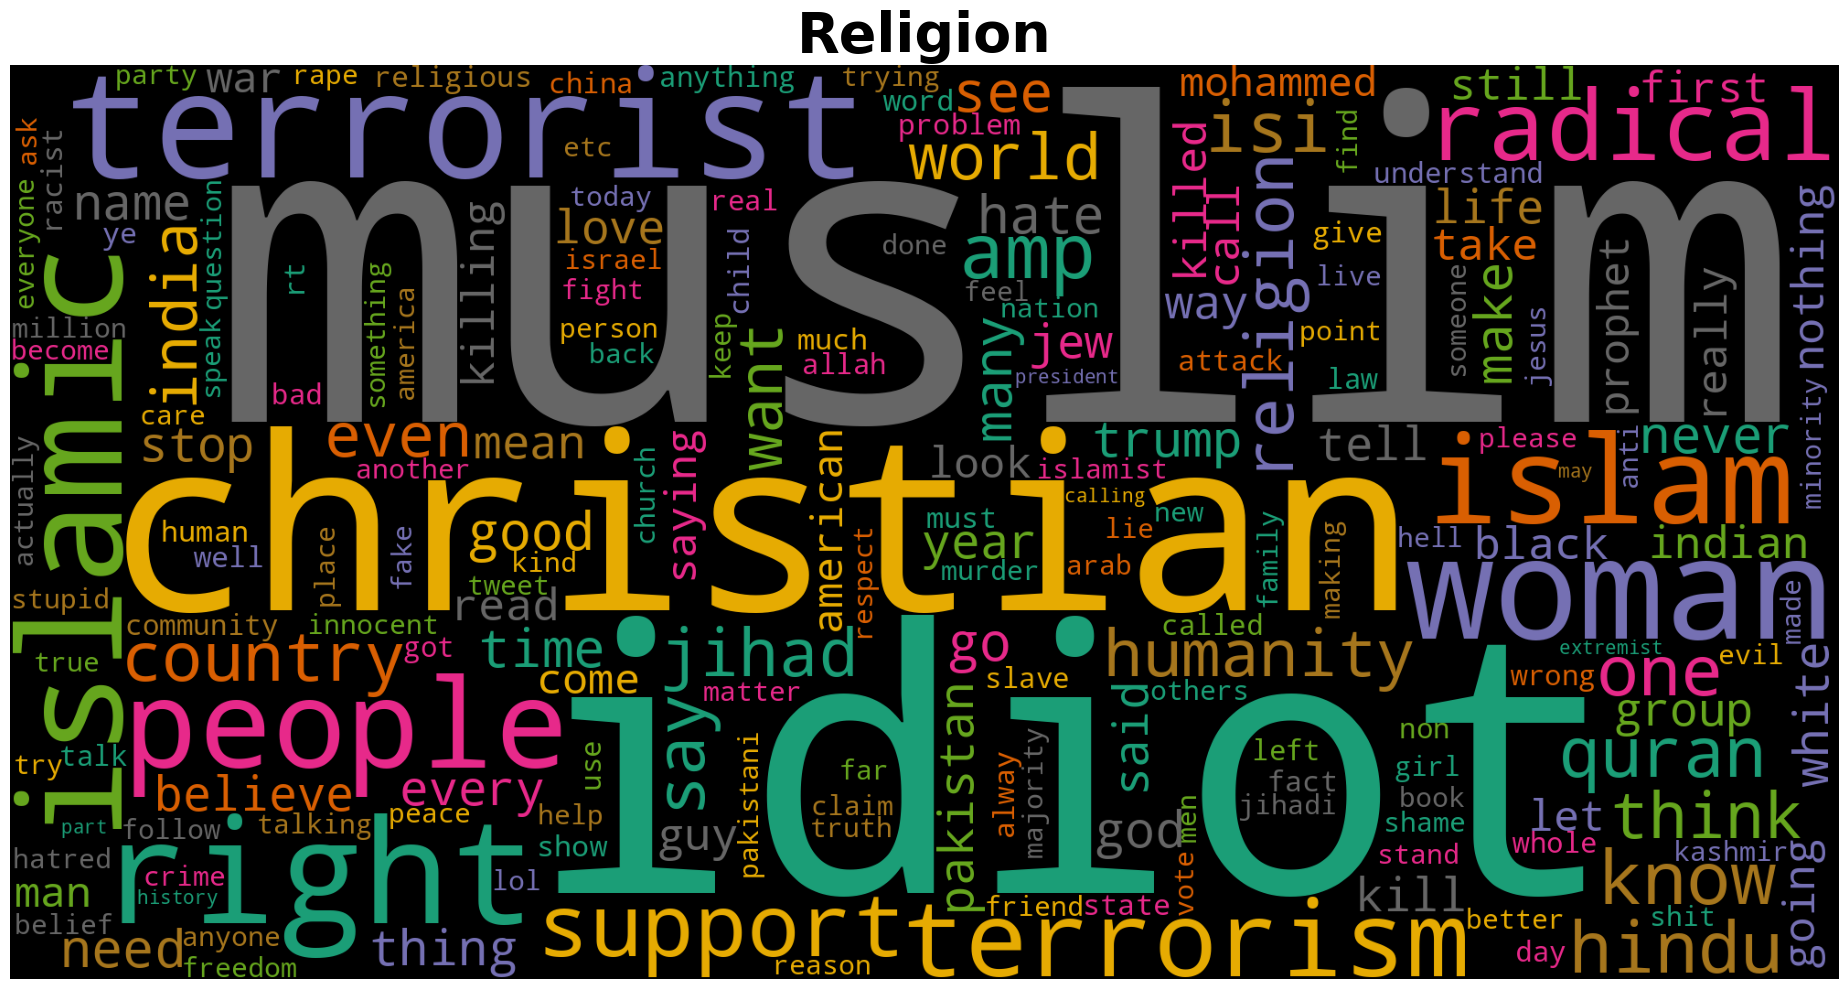

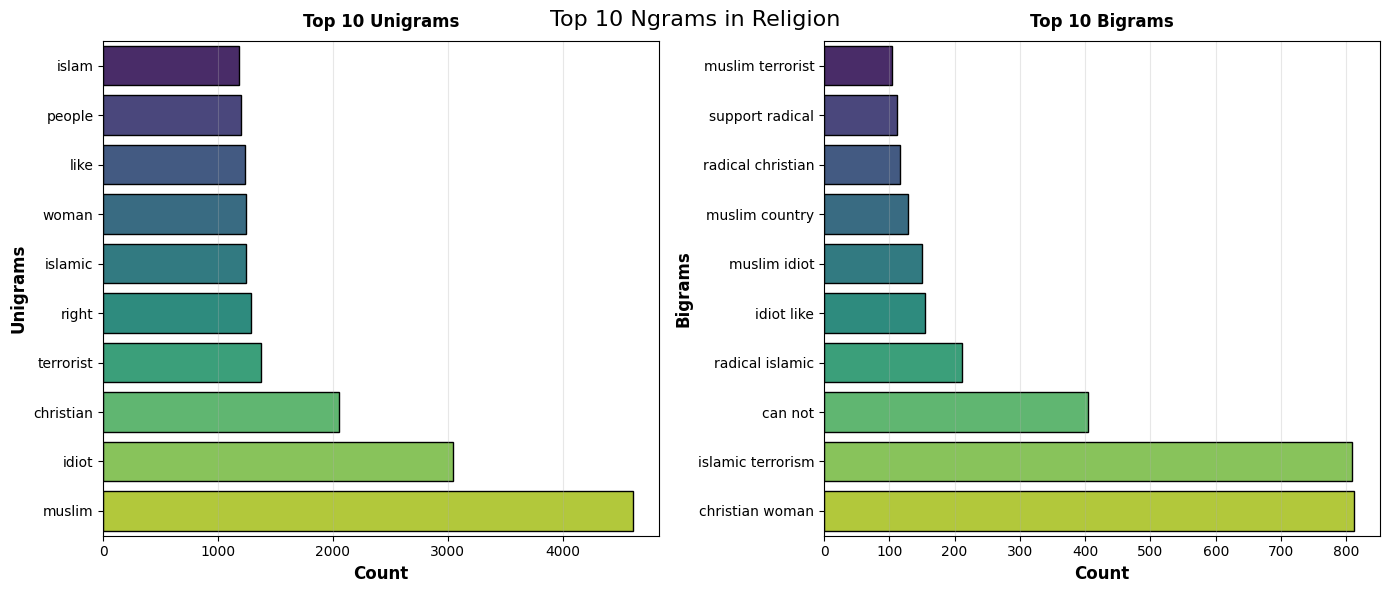

In [160]:
generate_wordcloud('religion', df)
plot_ngrams('religion', df)

### Age

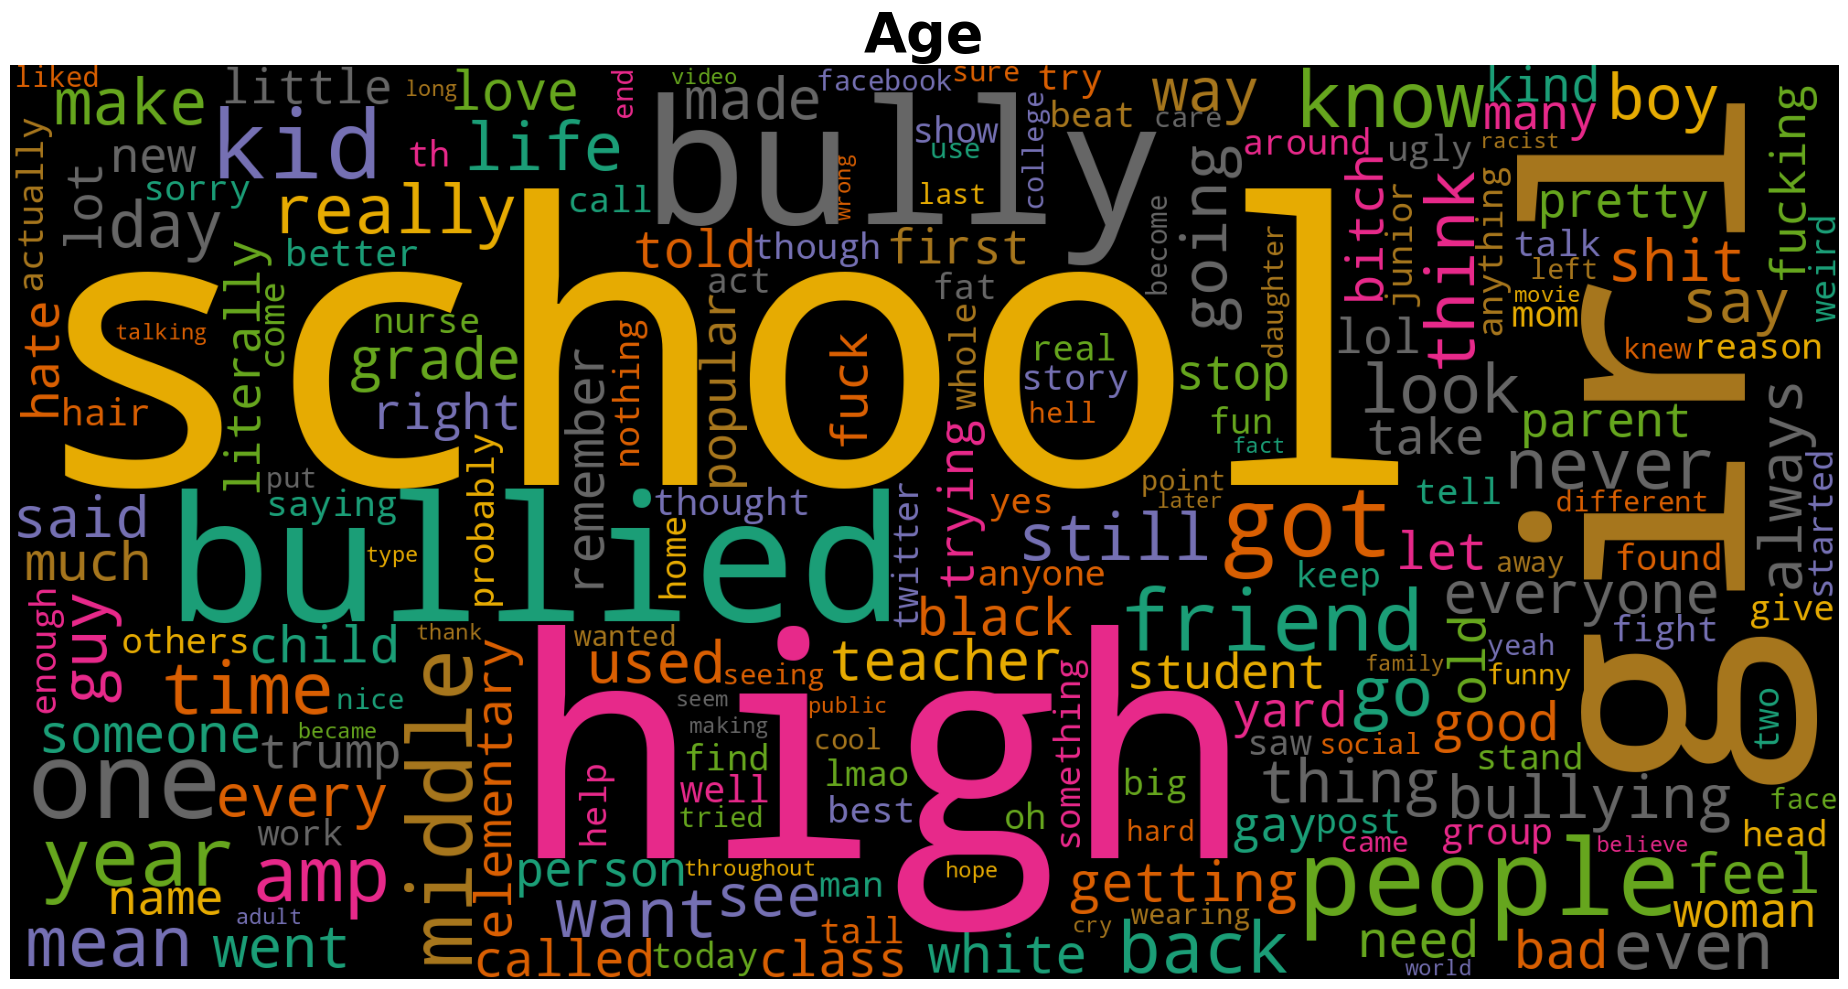

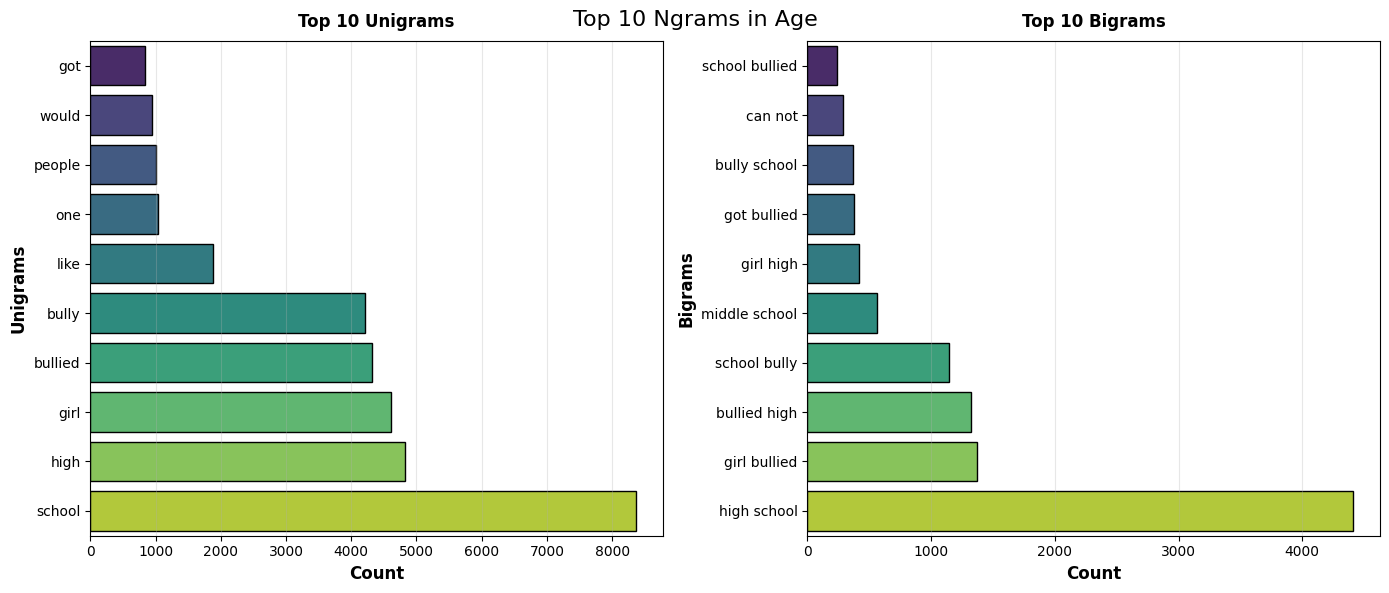

In [161]:
generate_wordcloud('age', df)
plot_ngrams('age', df)

### Ethnicity

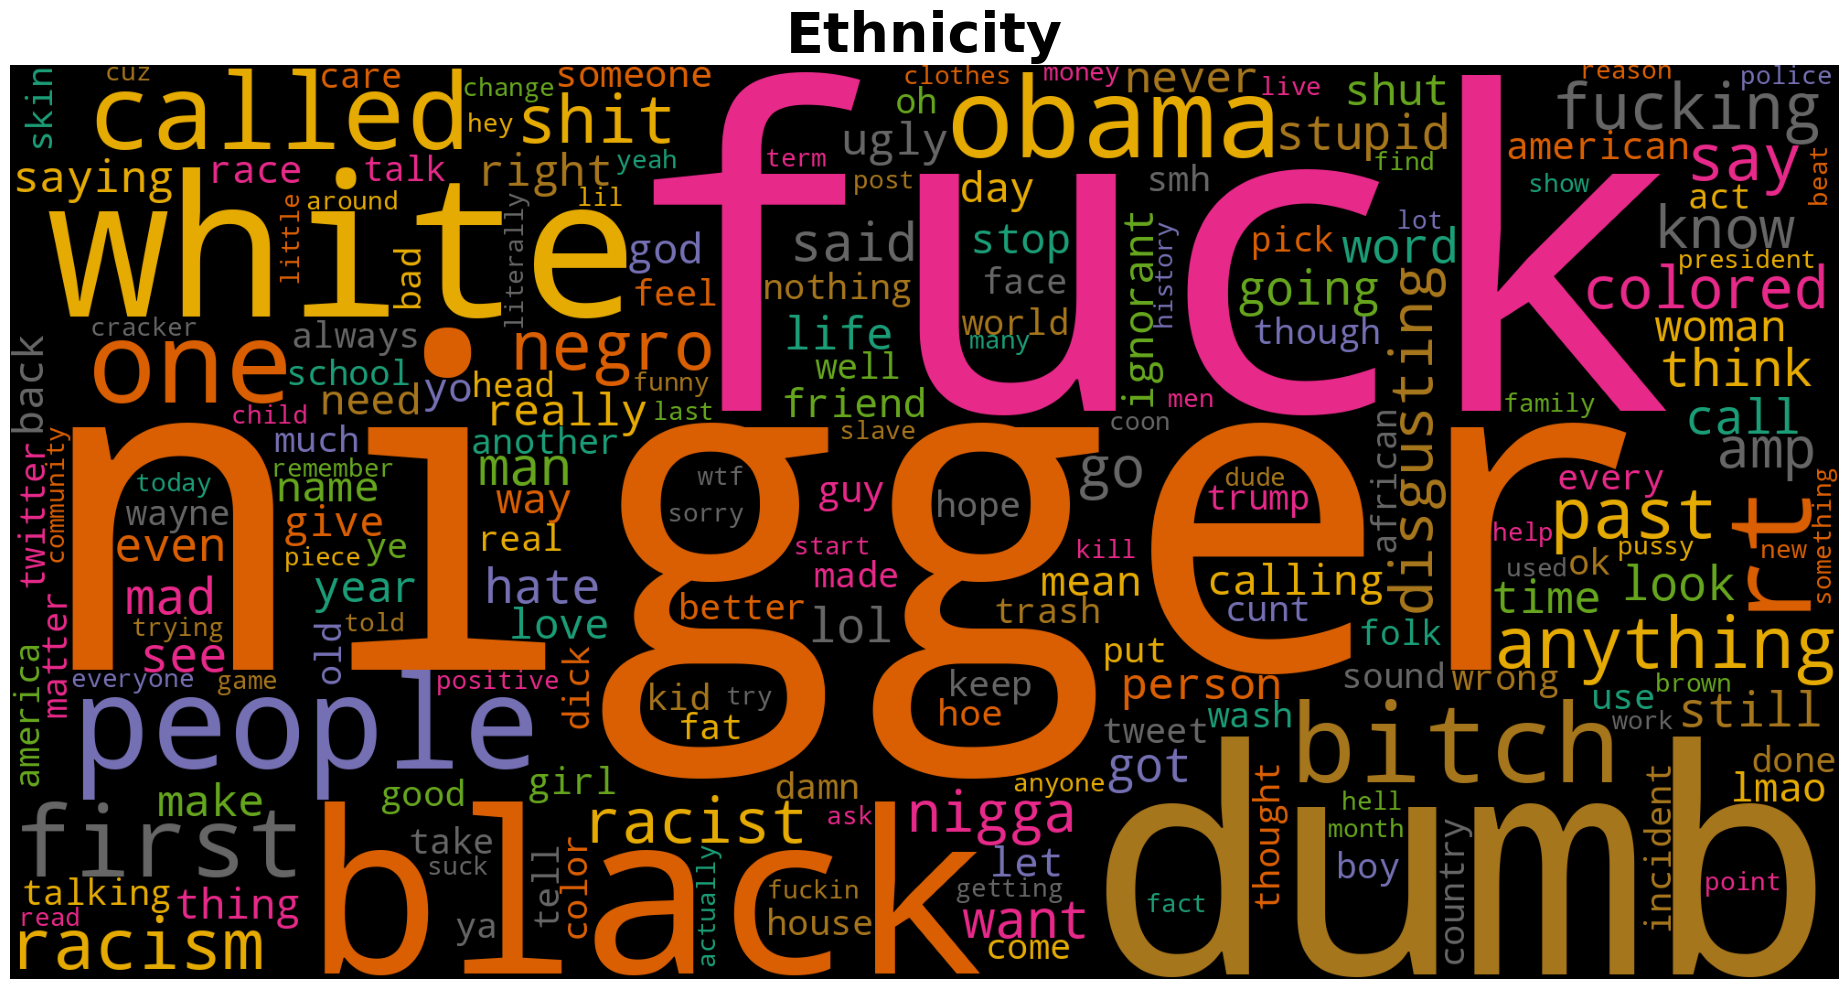

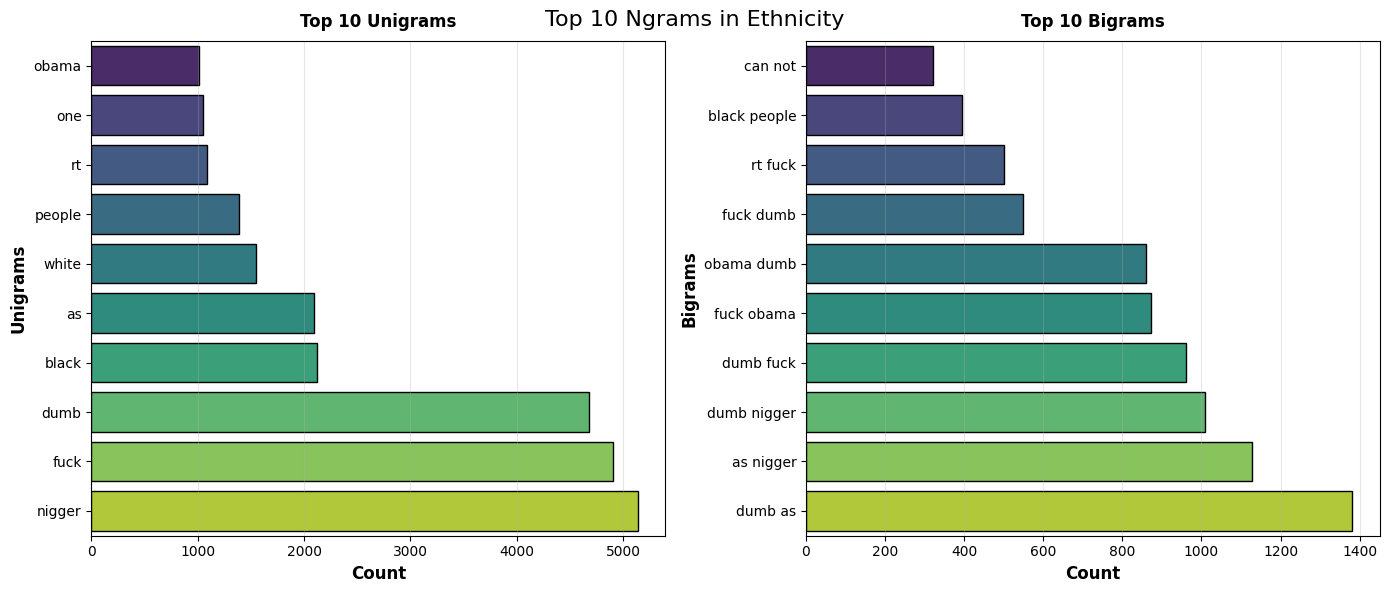

In [162]:
generate_wordcloud('ethnicity', df)
plot_ngrams('ethnicity', df)

### Gender

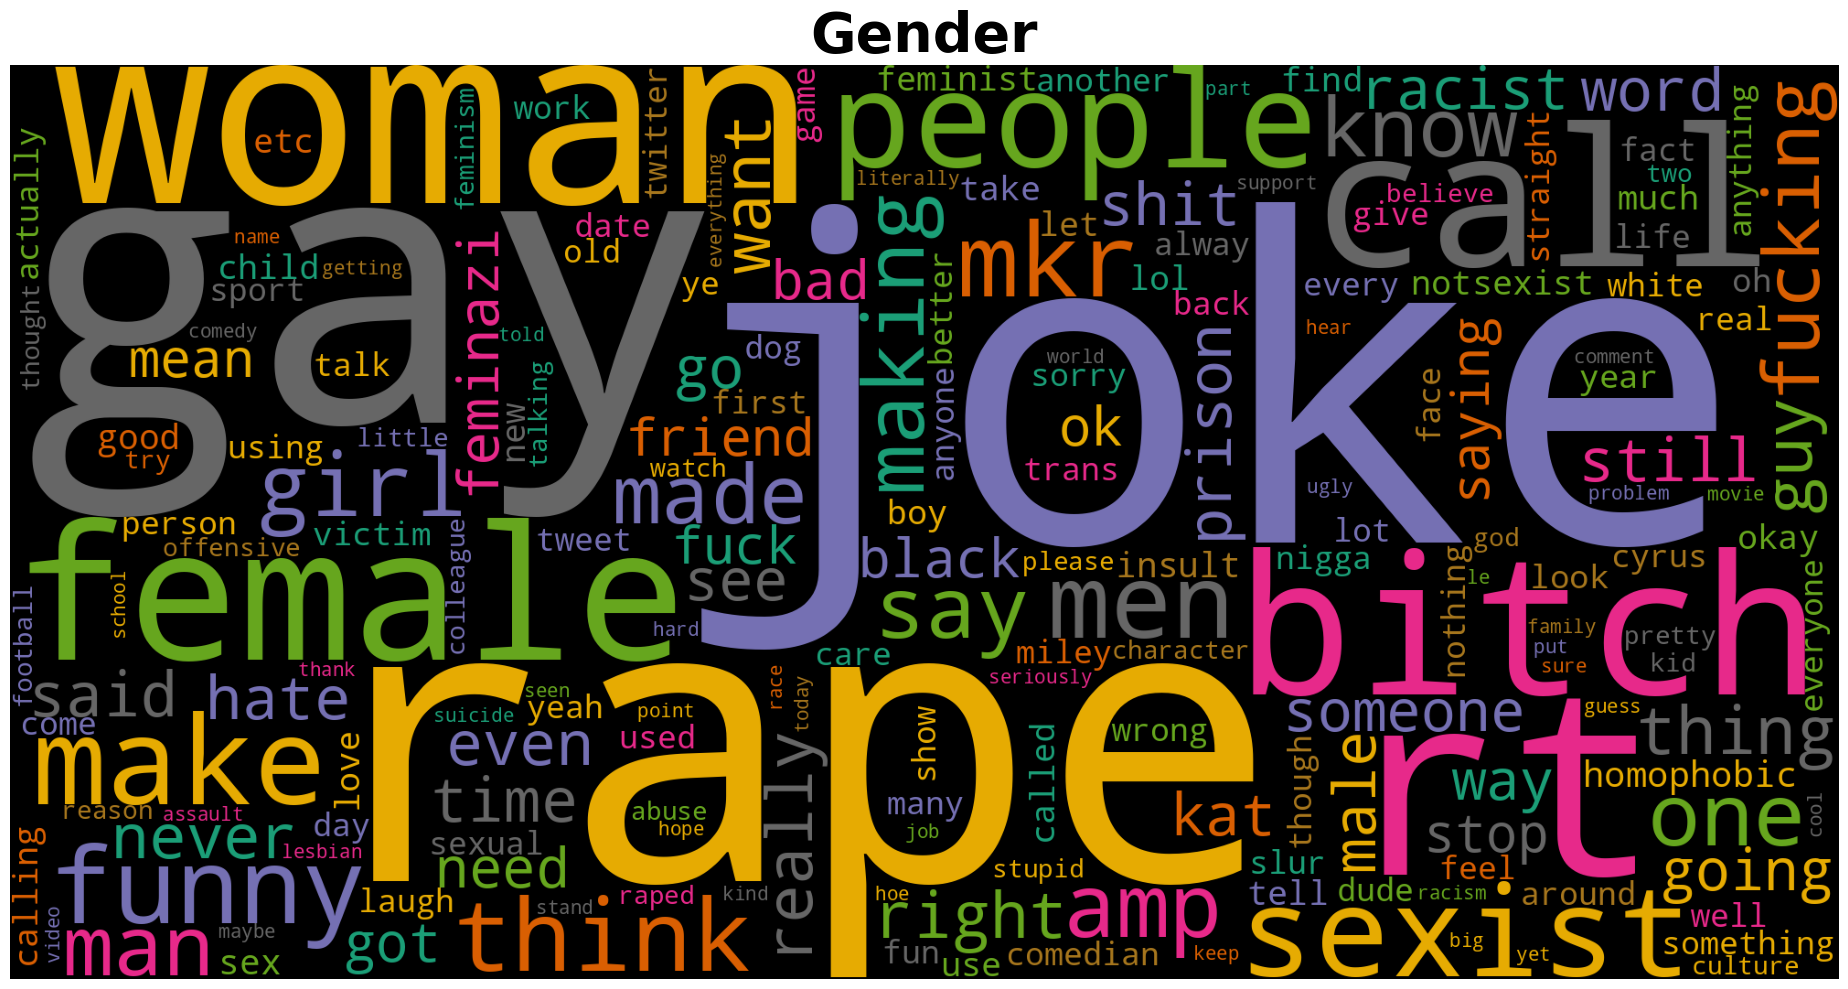

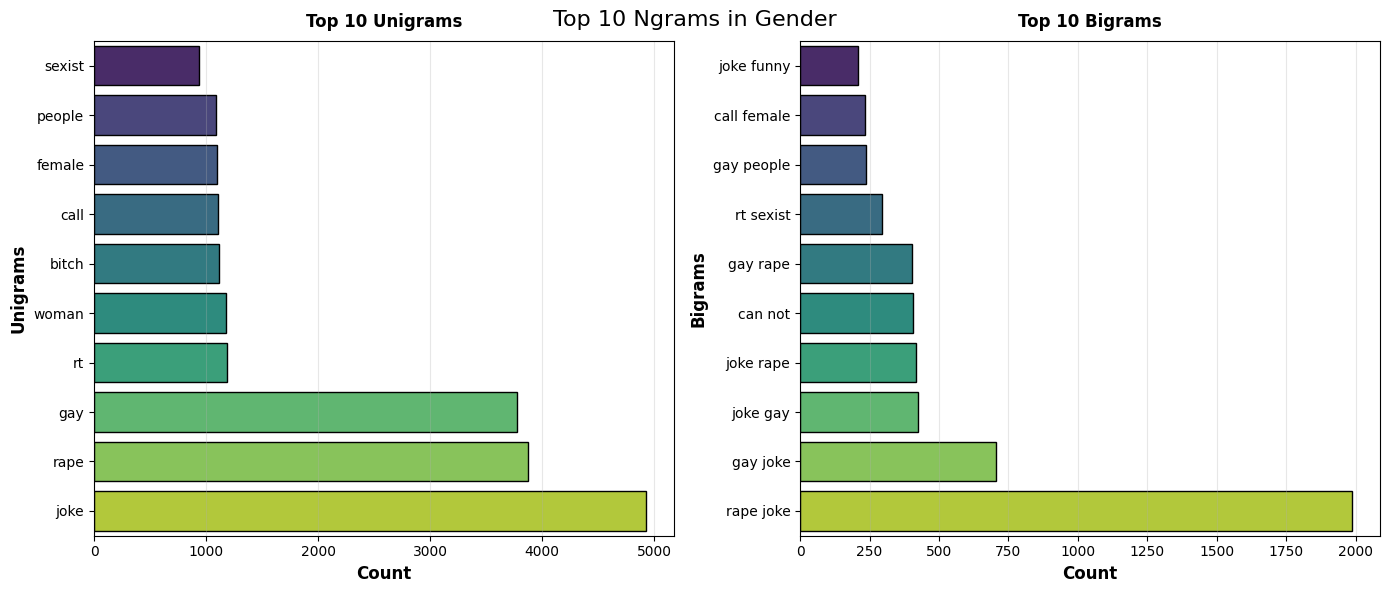

In [163]:
generate_wordcloud('gender', df)
plot_ngrams('gender', df)

### Other_cyberbullying

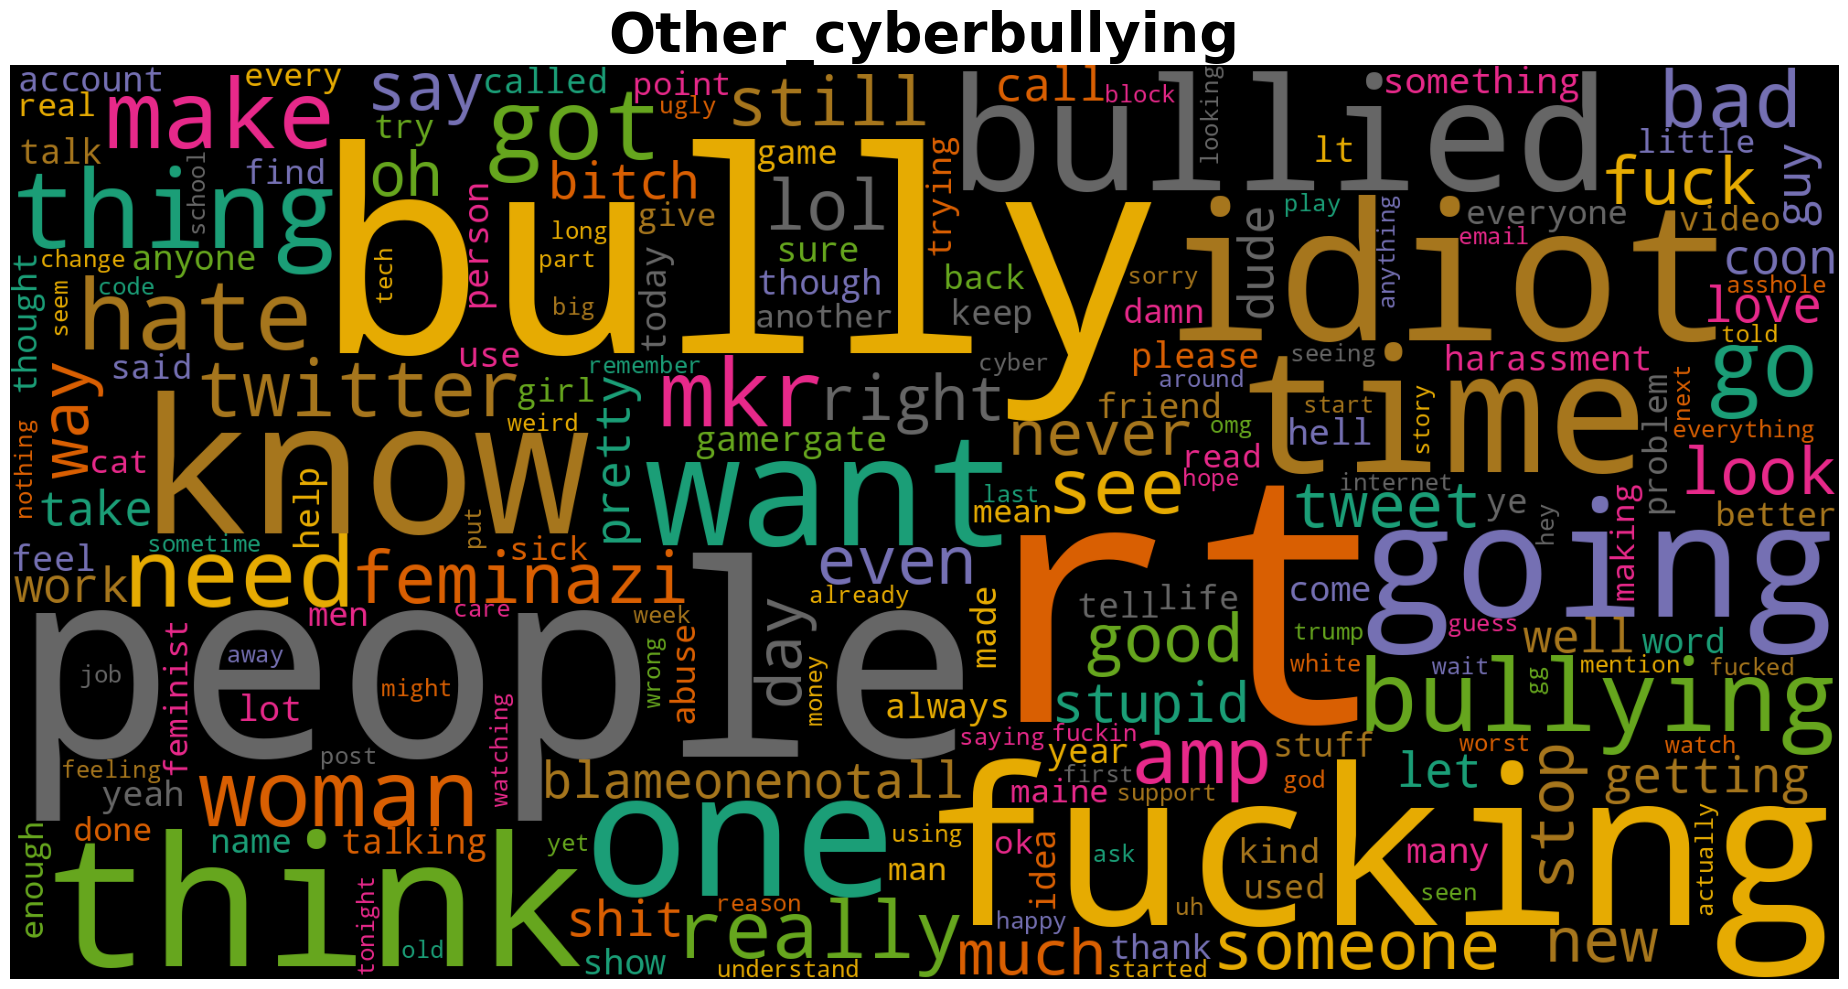

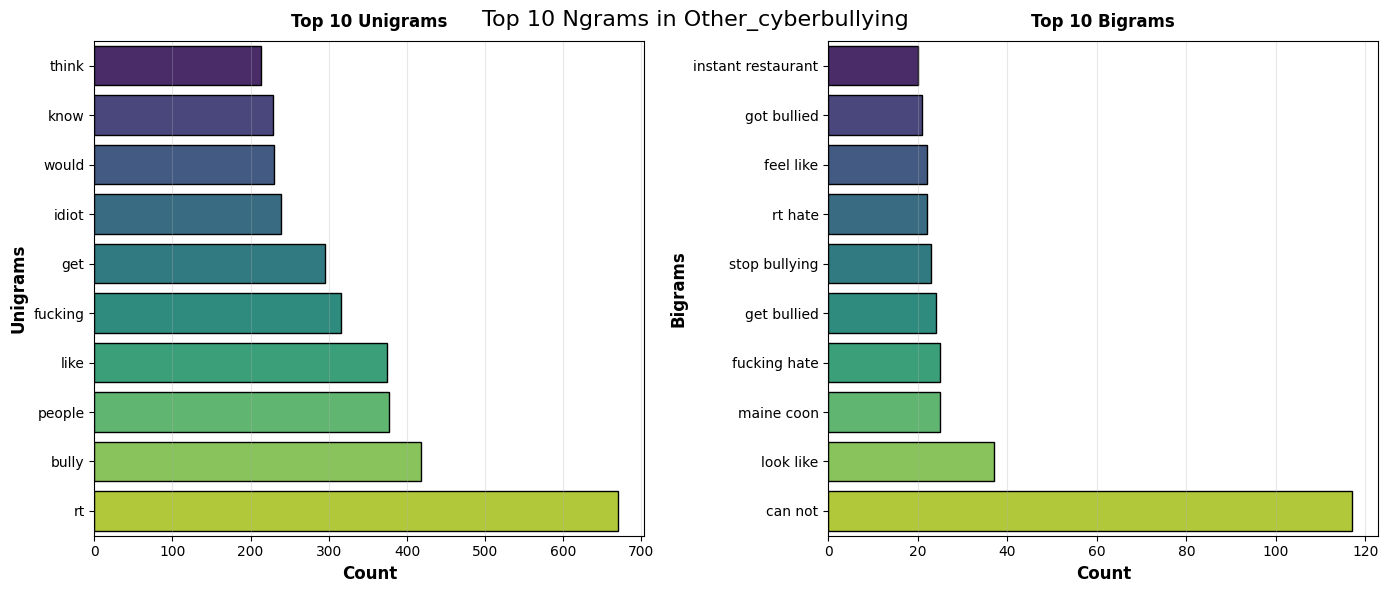

In [164]:
generate_wordcloud('other_cyberbullying', df)
plot_ngrams('other_cyberbullying', df)

### Not_cyberbullying

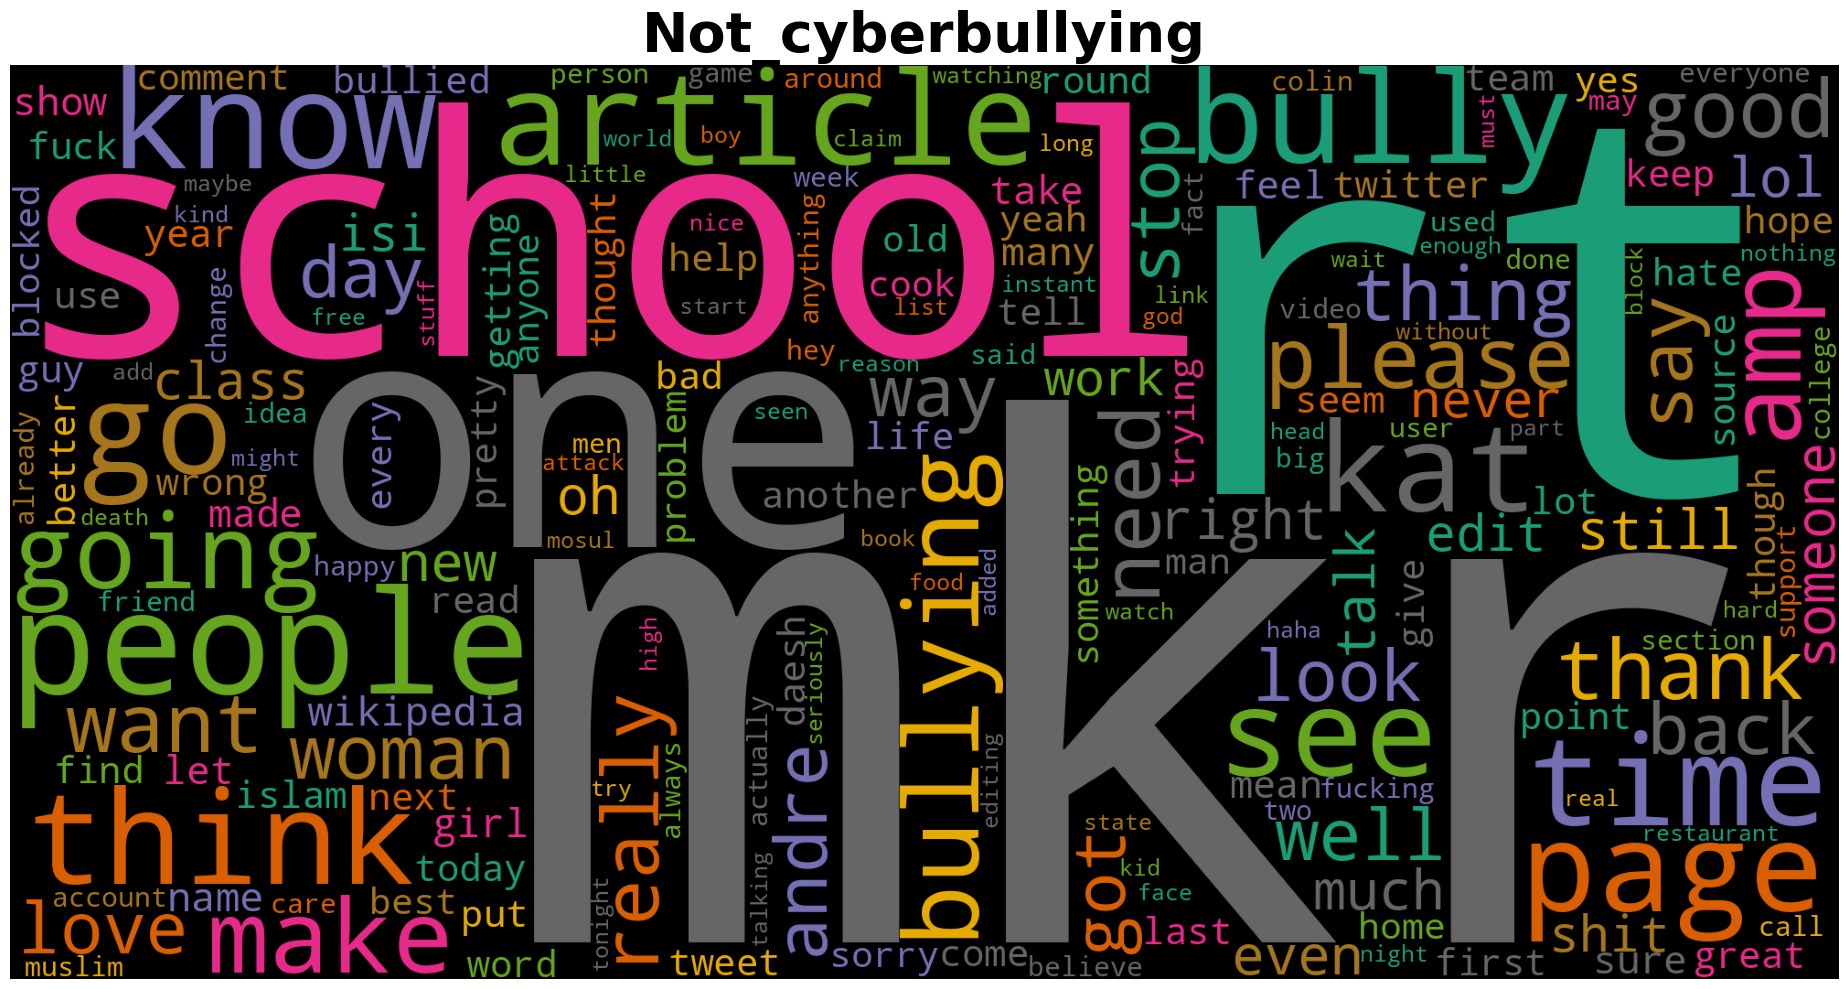

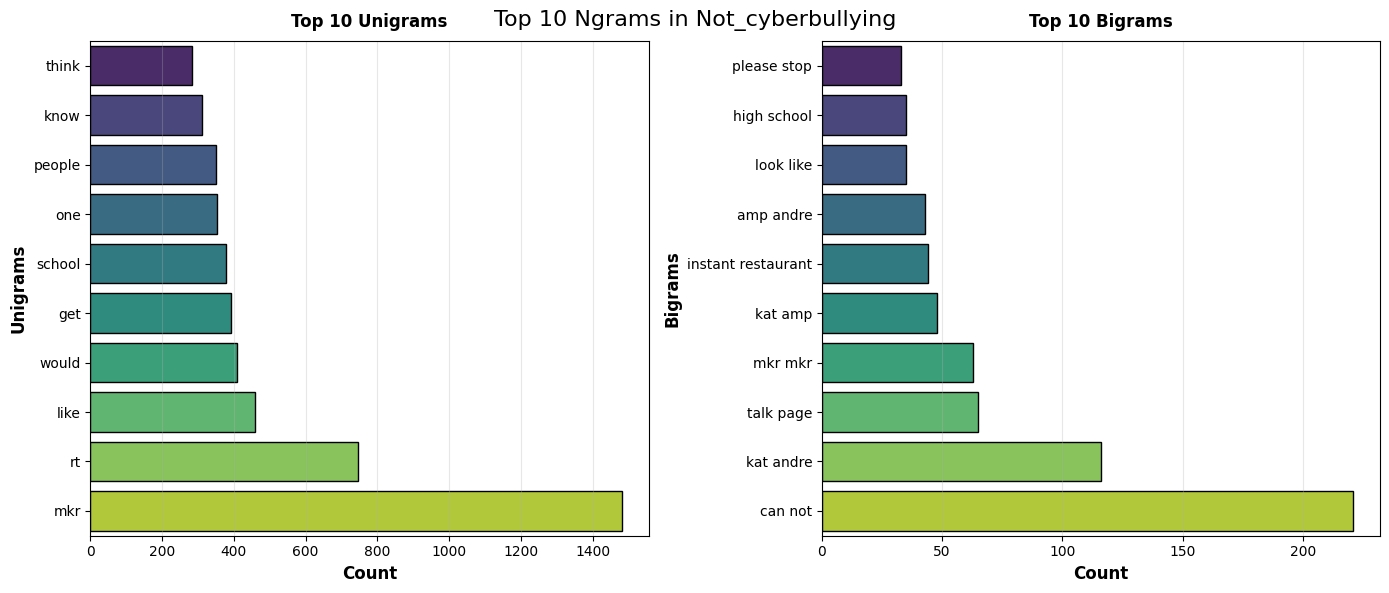

In [165]:
generate_wordcloud('not_cyberbullying', df)
plot_ngrams('not_cyberbullying', df)

As mentioned, a significant number of tweets belonging to the class "other_cyberbullying" have been observed to be removed. Due to the highly unbalanced nature of this class compared to others and its generic nature, a decision has been made to remove tweets labeled as belonging to this class.

Note: It has been noted that by performing some tests, the f1 score for predicting the "other_cyberbullying" class resulted to be around 60%, a value far lower compared to the other f1 scores (around 92% using LSTM model). This supports the decision to remove this class.

In [166]:
# Dropping the other_cyberBulling class
df = df[df["sentiment"]!="other_cyberbullying"]

In [167]:
#  5 sentiments exist in the dataset
sentiments = ["religion","age","ethnicity","gender","not bullying"]

<a name='2.2'></a>

## Tweets length analysis

In [168]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

In [169]:
# Sorting the rows based on the their lenths
df.sort_values(by=['text_len'], ascending=False)

text          sentiment  \
44035  You so black and white trying to live like a n...          ethnicity   
45165  @hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...          ethnicity   
1317   @EurekAlertAAAS: Researchers push to import to...  not_cyberbullying   
33724  ... I don't feel guilty for killing him, I jus...                age   
10922  don't make rape jokes!!! don't make gay jokes!...             gender   
...                                                  ...                ...   
19400  @truaemusic By hating the ideaology that enabl...           religion   
44713                       Ur first one that is so apt!          ethnicity   
7477   RT @Leonard_Delaney: Please RT http://t.co/Mtm...  not_cyberbullying   
8259               @kmx1974 Google "financial abortion".             gender   
6      Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying   

                                              text_clean  text_len  
44035  black white trying live like nigger pahahahaha...       173  
45165  fuck obama dumb as nigger bitch ltthis whore s...       151  
1317   researcher push import top antibullying progra...       138  
33724  feel guilty killing feel guilty enjoyed tormen...       136  
10922  make rape joke make gay joke oh fat joke okay ...       121  
...                                                  ...       ...  
19400                           hating ideaology enables         3  
44713                                      first one apt         3  
7477                                        rt please rt         3  
8259                           google financial abortion         3  
6                                                                0  

[38074 rows x 4 columns]

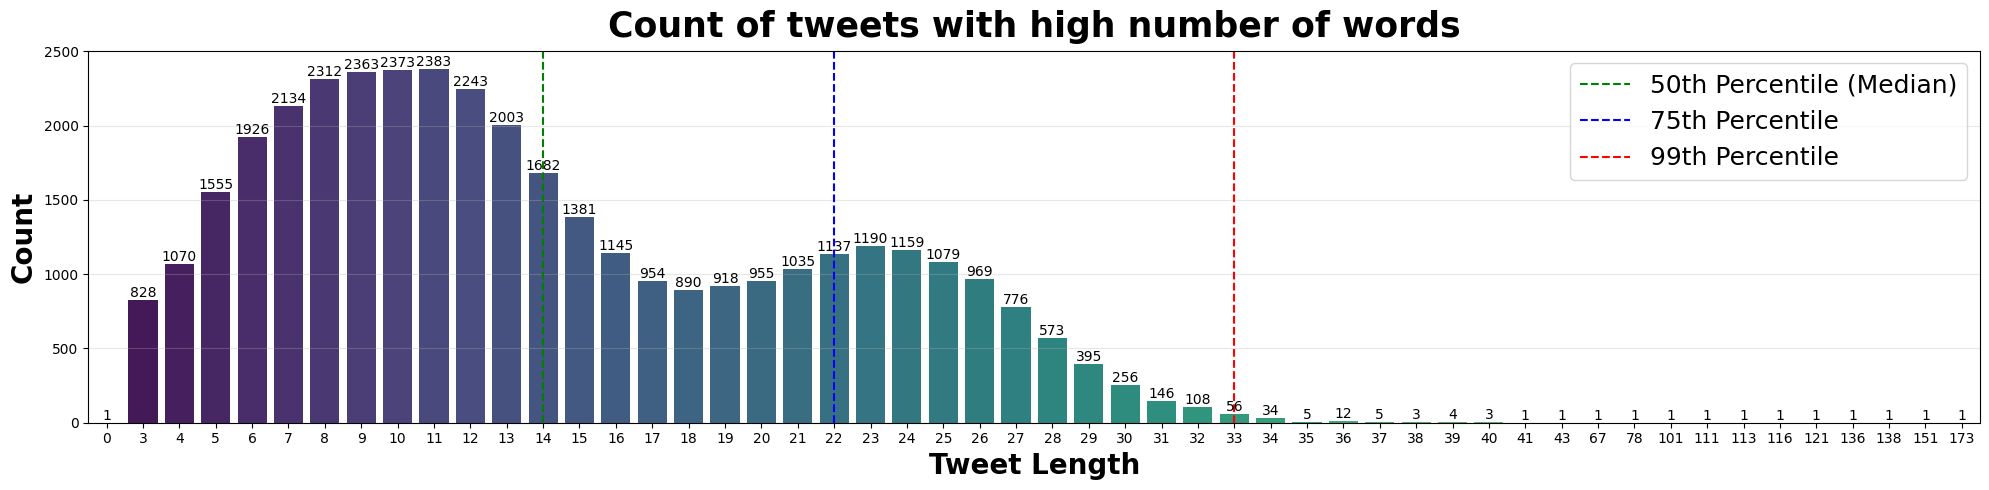

In [170]:
plt.figure(figsize=(20,5))
ax = sns.countplot(x='text_len', data=df, palette='viridis')
plt.title('Count of tweets with high number of words', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('Count', fontsize=20)
plt.xlabel('Tweet Length', fontsize=20)
ax.yaxis.grid(True, alpha=0.3)

# Calculate quartiles
q1 = np.percentile(df['text_len'], 25)
q2 = np.percentile(df['text_len'], 50)
q3 = np.percentile(df['text_len'], 75)
q4 = np.percentile(df['text_len'], 99)


# Add lines for quartiles
plt.axvline(x=q2, color='green', linestyle='--', label='50th Percentile (Median)')
plt.axvline(x=q3, color='blue', linestyle='--', label='75th Percentile')
plt.axvline(x=q4, color='red', linestyle='--', label='99th Percentile')


plt.legend(fontsize = 18)

# Save the plot as SVG
#plt.savefig('tweet_length_plot_with_quartiles.svg', format='svg', bbox_inches='tight')

plt.show()

To organise computational time, a new variable called text_len introduced to represent the word count for each tweet. Figure highlights tweet length distribution, indicating potential outliers beyond the 99th percentile. To optimize efficiency, rows exceeding the 0.99 quantile are removed. As a result, tweets with lengths exceeding 31 are eliminated, and the maximum length for all tweets is capped at 31.

In [171]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

In [172]:
df['sentiment'].value_counts()

sentiment
religion             7839
age                  7760
not_cyberbullying    7631
ethnicity            7366
gender               7235
Name: count, dtype: int64

The length of the longest tweet is also obtained since it will be useful later.

In [173]:
max_len = np.max(df['text_len'])
max_len 

31

In [174]:
df.sort_values(by=["text_len"], ascending=False)

text          sentiment  \
95625  `  == Thank u ==  {| style=``background-color:...  not_cyberbullying   
15094  A little shite bag Rowan Croft / Gem Trails O´...             gender   
20467  Ohhh really?? Thts what your Pakistani media t...           religion   
32997  name calling = one of the worst forms of bully...                age   
14162  Those women support Linda Sarsour (who openly ...             gender   
...                                                  ...                ...   
19517  @dankmtl @AAlwuhaib1977 @PeaceNotHate_ No assh...           religion   
44702                          ur first one it just fits          ethnicity   
17809                       Reggae is for wrist warriors  not_cyberbullying   
43223                  Anything past 8x04 doesn't exist.          ethnicity   
6      Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying   

                                              text_clean  text_len  
95625  thank stylebackgroundcolor fdffe border px sol...        31  
15094  little shite bag rowan croft gem trail odohert...        31  
20467  oh really thts pakistani medium tell kashmiri ...        31  
32997  name calling one worst form bullying bullied l...        31  
14162  woman support linda sarsour openly support lea...        31  
...                                                  ...       ...  
19517                          asshole israeli defending         3  
44702                                      first one fit         3  
17809                               reggae wrist warrior         3  
43223                                anything past exist         3  
6                                                                0  

[37831 rows x 4 columns]

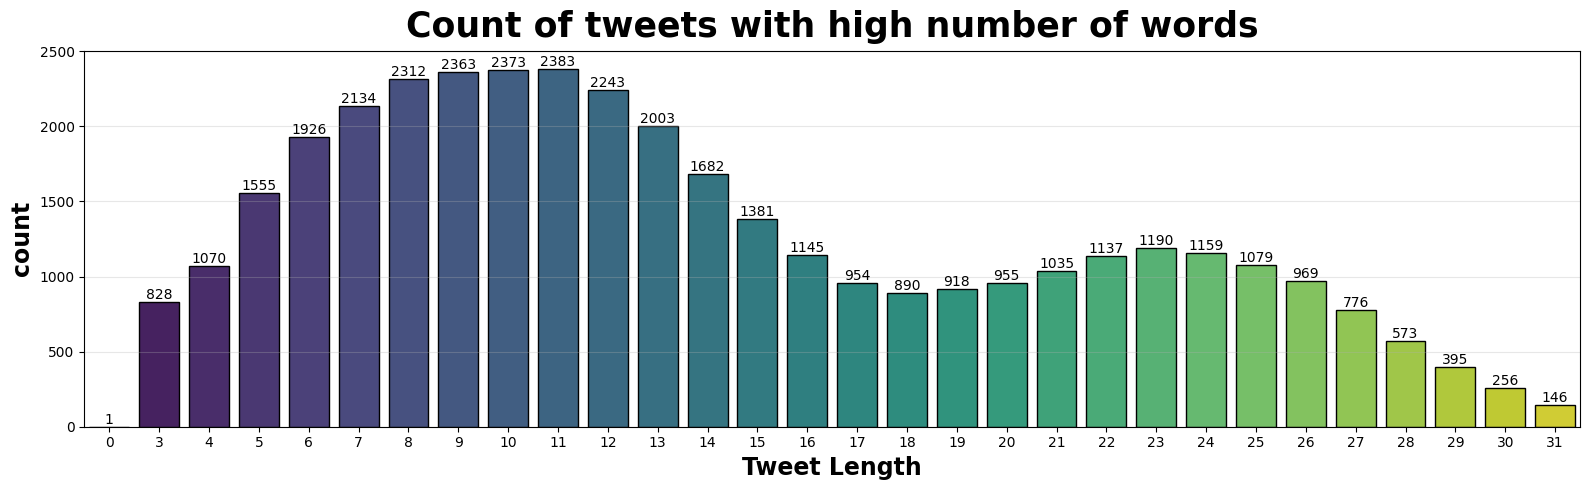

In [175]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df, edgecolor = 'black',palette='viridis')
plt.title('Count of tweets with high number of words', fontsize=25)
ax.bar_label(ax.containers[0])
plt.ylabel('count', fontsize = 17)
plt.xlabel('Tweet Length', fontsize = 17)
ax.yaxis.grid(True, alpha = 0.3)
#plt.savefig('tweet_length_plot_after_filter.svg', format='svg', bbox_inches='tight')
plt.show()

<a name='3'></a>

# Traditional models

### Sentiment column encoding

The target column will be encoded


In [176]:
df['sentiment_code'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

### Train - Test split

In [177]:
df['sentiment_code'].unique()

array([4, 3, 0, 1, 2])

In [178]:
X = df['text_clean']
y = df['sentiment_code']

In [179]:
# using shuffle to ensure that each set (training and testing) contains a representative sample of each category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value, shuffle=True)

In [180]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6271],
       [   1, 6208],
       [   2, 5893],
       [   3, 5788],
       [   4, 6104]])

The classes are not completely balanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one. The RandomOverSampler in Python's imbalanced-learn library is used to balance the class distribution by randomly duplicating samples from the minority class. Given the moderate level of imbalance, oversampling seems like an appropriate approach that shouldn't lead to overfitting issues and does not have the problem of sampling in NLP tasks.

### Oversampling of training set

In [181]:
y_train.value_counts()

sentiment_code
0    6271
1    6208
4    6104
2    5893
3    5788
Name: count, dtype: int64

In [182]:
# using RAndomoverSampler to completely balance the data
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [183]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [184]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6271],
       [   1, 6271],
       [   2, 6271],
       [   3, 6271],
       [   4, 6271]])

First, creating a bag of words using CountVectorizer.

In [185]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

The TF-IDF transformation is applied to associate weights to the different words based on their frequency (rarer words will be given more importance).

In [186]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

### Grid Search and Evaluation Functions

In [187]:
def perform_grid_search(clf, param_grid, X, y):
    """
    Performing grid search to find the best hyperparameters.
    """

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy',n_jobs=-1)

    # Perform grid search on training data
    grid_search.fit(X, y)

    # Best parameters and the best accuracy score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_score)

    return grid_search

In [188]:
##old eval
def evaluate_classification_with_model2(model_name, model, X_test, y_true, sentiments):
    evaluation_results = {}
    evaluation_results['Model'] = model_name

    if hasattr(model, "predict_proba"):  # traditional models
        y_pred_probs = model.predict_proba(X_test)

        # Predicted classes
        y_pred = model.predict(X_test)

    else:  # neural network models
        # Predicted probabilities
        y_pred_probs = model.predict(X_test)

        # Predicted classes
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    evaluation_results['Accuracy'] = accuracy

    # Precision, Recall, F1-score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    evaluation_results['Precision'] = precision
    evaluation_results['Recall'] = recall
    evaluation_results['F1-score'] = f1

    # ROC-AUC for multi-class classification
    roc_auc = []
    for i in range(len(sentiments)):
        roc_auc.append(roc_auc_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['ROC-AUC'] = np.mean(roc_auc)

    # PR-AUC for multi-class classification
    pr_auc = []
    for i in range(len(sentiments)):
        pr_auc.append(average_precision_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['PR-AUC'] = np.mean(pr_auc)

    # ROC curve plotting
    plt.figure(figsize=(5, 5))
    for i, sentiment in enumerate(sentiments):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve ({sentiment}) (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classification')
    plt.legend(loc="lower right", fontsize=12)

    plt.show()

    # Print evaluation metrics with correct formatting
    for key, value in evaluation_results.items():
        if isinstance(value, (int, float)):  # Check if the value is numeric
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

    return evaluation_results


In [189]:
##separate plotting
def separate_plotting(model_name, model, X_test, y_true, sentiments):

    evaluation_results = {}
    evaluation_results['Model'] = model_name

    if hasattr(model, "predict_proba"):  # traditional models
        y_pred_probs = model.predict_proba(X_test)

        # Predicted classes
        y_pred = model.predict(X_test)

    else:  # neural network models
        # Predicted probabilities
        y_pred_probs = model.predict(X_test)

        # Predicted classes
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    evaluation_results['Accuracy'] = accuracy

    # Precision, Recall, F1-score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    evaluation_results['Precision'] = precision
    evaluation_results['Recall'] = recall
    evaluation_results['F1-score'] = f1

    # ROC-AUC for multi-class classification
    roc_auc = []
    for i in range(len(sentiments)):
        roc_auc.append(roc_auc_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['ROC-AUC'] = np.mean(roc_auc)

    # PR-AUC for multi-class classification
    pr_auc = []
    for i in range(len(sentiments)):
        pr_auc.append(average_precision_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['PR-AUC'] = np.mean(pr_auc)


    # ROC curve plotting
    plt.figure(figsize=(5, 5))
    for i, sentiment in enumerate(sentiments):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve ({sentiment}) (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classification')
    plt.legend(loc="lower right", fontsize=12)

    plt.show()


In [190]:
list_of_evaluations = []
runtime = {}

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_with_model(name, model, X_test, y_test, target_names):
    y_pred = model.predict(X_test)

    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }
    if hasattr(model, "predict_proba"):  # traditional models
        y_pred_probs = model.predict_proba(X_test)

        # Predicted classes
        y_pred = model.predict(X_test)

    else:  # neural network models
        # Predicted probabilities
        y_pred_probs = model.predict(X_test)

        # Predicted classes
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    evaluation_results['Accuracy'] = accuracy

    # Precision, Recall, F1-score
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    evaluation_results['Precision'] = precision
    evaluation_results['Recall'] = recall
    evaluation_results['F1-score'] = f1

    # ROC-AUC for multi-class classification
    roc_auc = []
    for i in range(len(sentiments)):
        roc_auc.append(roc_auc_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['ROC-AUC'] = np.mean(roc_auc)

    # PR-AUC for multi-class classification
    pr_auc = []
    for i in range(len(sentiments)):
        pr_auc.append(average_precision_score(y_true == i, y_pred_probs[:, i]))
    evaluation_results['PR-AUC'] = np.mean(pr_auc)

    # ROC curve plotting
    plt.figure(figsize=(5, 5))
    for i, sentiment in enumerate(sentiments):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve ({sentiment}) (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name} Classification')
    plt.legend(loc="lower right", fontsize=12)

    plt.show()

    # Print evaluation metrics with correct formatting
    for key, value in evaluation_results.items():
        if isinstance(value, (int, float)):  # Check if the value is numeric
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")

    return evaluation_results


In [191]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(6.5,6.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="viridis", fmt='g', cbar=False, annot_kws={"size":20})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=15.5) 
    ax.yaxis.set_ticklabels(labels, fontsize=15.5)
    ax.set_ylabel('Test', fontsize=15)
    ax.set_xlabel('Predicted', fontsize=15)

    file_name = f"{title}_confusion_matrix.svg"
    #plt.savefig(file_name, format='svg', bbox_inches='tight')
    plt.show()

<a name='3.1'></a>

## Random Forest
As the dataset is large and the model size is too big for using gridSearch in Random Forest, hyperparameters such as n_estimators, max_depth, and min_samples_split are manually tuned. The parameters that lead to better results than the default settings are selected and used to train the final model.

In [192]:
list_of_evaluations = [] # this list of all models' evaluations
runtime = {} # a dictionary containing all model's runtimes

In [193]:
start_time = time.time()

rf_clf = RandomForestClassifier(n_estimators=150)
rf_clf.fit(X_train_tf, y_train)

end_time = time.time()

# Calculate the runtime
runtime['RF'] = end_time - start_time

In [194]:
runtime

{'RF': 87.09640002250671}

Classification Report for Random Forest:
               precision    recall  f1-score   support

    religion       0.97      0.96      0.96      1568
         age       0.98      0.97      0.98      1552
   ethnicity       0.99      0.99      0.99      1473
      gender       0.95      0.85      0.90      1447
not bullying       0.82      0.92      0.87      1527

    accuracy                           0.94      7567
   macro avg       0.94      0.94      0.94      7567
weighted avg       0.94      0.94      0.94      7567



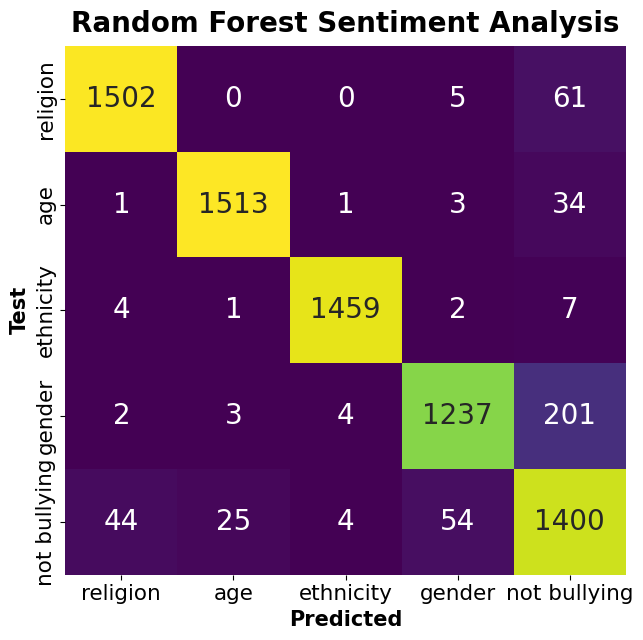

In [195]:
rf_pred = rf_clf.predict(X_test_tf)

print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiments))
conf_matrix(y_test,rf_pred,'Random Forest Sentiment Analysis', sentiments)

In [196]:
## download this model 
import joblib

# Save model
joblib.dump(rf_clf, 'logistic_regression_model.pkl')

# Save vectorizer and transformer
joblib.dump(clf, 'count_vectorizer.pkl')
joblib.dump(tf_transformer, 'tfidf_transformer.pkl')

# Save sentiments list if needed
import json
with open('sentiments.json', 'w') as f:
    json.dump(sentiments, f)


In [ ]:
list_of_evaluations.append(evaluate_classification_with_model('RF', rf_clf, X_test_tf, y_test,sentiments))
separate_plotting('RF', rf_clf, X_test_tf, y_test,sentiments)

<a name='3.2'></a>

## Gradient Boosting Classifier
As the dataset is large and the model size is too big for using gridSearch in GB, hyperparameters such as n_estimators and max_depth are manually tuned. The parameters that lead to better results than the default settings are selected and used to train the final model.

Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

    religion       0.97      0.93      0.95      1568
         age       0.99      0.97      0.98      1552
   ethnicity       0.99      0.98      0.99      1473
      gender       0.94      0.85      0.90      1447
not bullying       0.79      0.93      0.86      1527

    accuracy                           0.93      7567
   macro avg       0.94      0.93      0.93      7567
weighted avg       0.94      0.93      0.93      7567



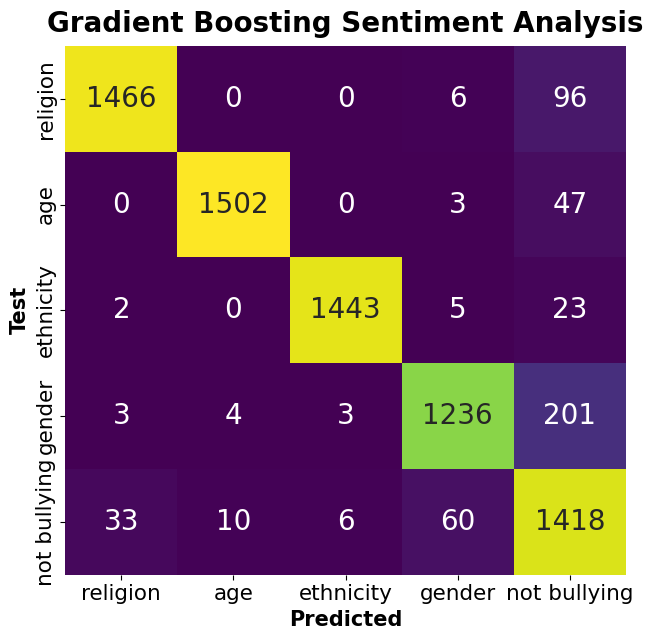

In [198]:
start_time = time.time()

gb_clf = GradientBoostingClassifier(n_estimators=150)
gb_clf.fit(X_train_tf, y_train)
end_time = time.time()

# Calculate the runtime
runtime['GB'] = end_time - start_time

gb_pred = gb_clf.predict(X_test_tf)

print('Classification Report for Gradient Boosting:\n',classification_report(y_test, gb_pred, target_names=sentiments))
conf_matrix(y_test,gb_pred,'Gradient Boosting Sentiment Analysis', sentiments)

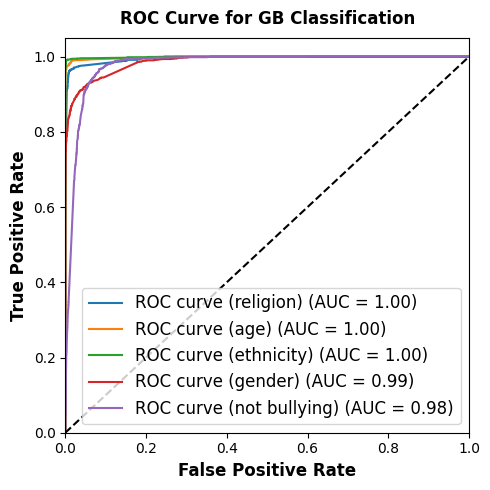

In [199]:
list_of_evaluations.append(evaluate_classification_with_model('GB', gb_clf, X_test_tf, y_test,sentiments))
separate_plotting('GB', gb_clf, X_test_tf, y_test,sentiments)

<a name='3.3'></a>

## Multinomial Naive Bayes classifier
GridSearch is used to find the best hyper parameters

In [200]:
# Defining the parameter grid
nb_param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
}
# Initialize Multinomial Naive Bayes classifier
start_time = time.time()
clf = MultinomialNB()

nb_clf = perform_grid_search(clf, nb_param_grid, X_train_tf, y_train)
end_time = time.time()
runtime['NB'] = end_time - start_time

Best Parameters: {'alpha': 0.5}
Best Accuracy Score: 0.8560357199808643


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.84      0.96      0.90      1568
         age       0.81      0.96      0.88      1552
   ethnicity       0.89      0.90      0.90      1473
      gender       0.87      0.85      0.86      1447
not bullying       0.83      0.56      0.67      1527

    accuracy                           0.85      7567
   macro avg       0.85      0.85      0.84      7567
weighted avg       0.85      0.85      0.84      7567



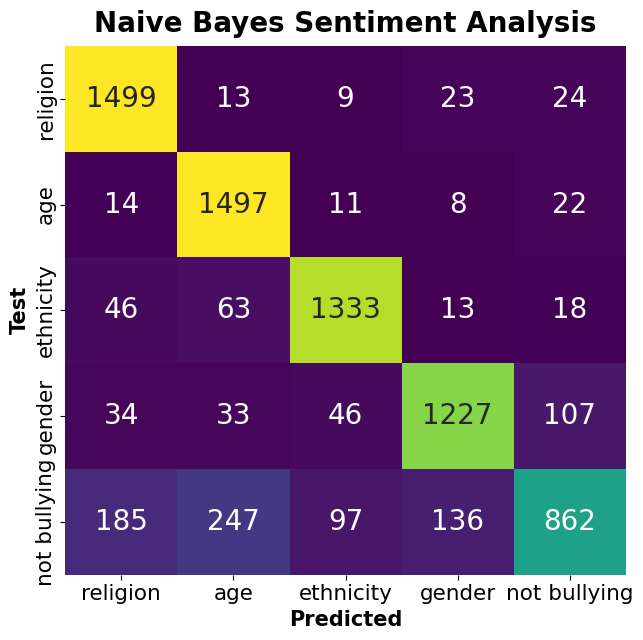

In [201]:
nb_pred = nb_clf.predict(X_test_tf)

print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis', sentiments)

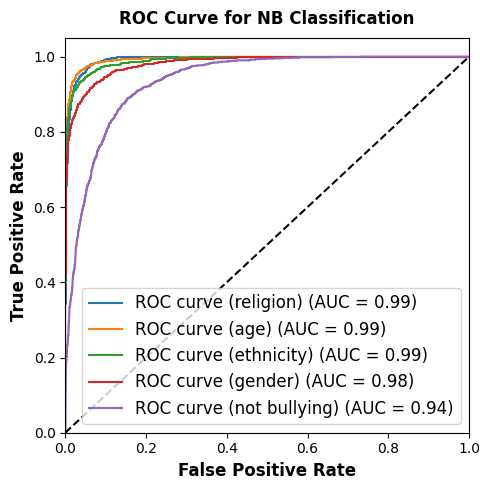

In [202]:
# evaluation_result = evaluating_new(nb_clf, X_test_tf, y_test, 'Naive Bayes')
list_of_evaluations.append(evaluate_classification_with_model('NB', nb_clf, X_test_tf, y_test, sentiments))
separate_plotting('NB', nb_clf, X_test_tf, y_test,sentiments)

<a name='3.4'></a>

## LogisticRegression

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

    religion       0.97      0.94      0.95      1568
         age       0.94      0.97      0.96      1552
   ethnicity       0.97      0.98      0.98      1473
      gender       0.94      0.87      0.90      1447
not bullying       0.81      0.86      0.84      1527

    accuracy                           0.93      7567
   macro avg       0.93      0.93      0.93      7567
weighted avg       0.93      0.93      0.93      7567



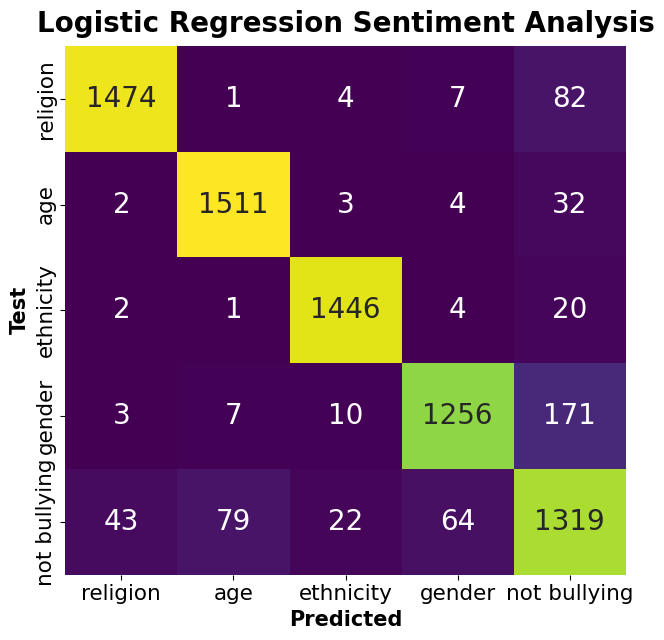

In [203]:
start_time = time.time()

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train_tf, y_train)

end_time = time.time()
runtime['LR'] = end_time - start_time

lr_pred = lr_clf.predict(X_test_tf)

print('Classification Report for Logistic Regression:\n',classification_report(y_test, lr_pred, target_names=sentiments))

conf_matrix(y_test,lr_pred,'Logistic Regression Sentiment Analysis', sentiments)

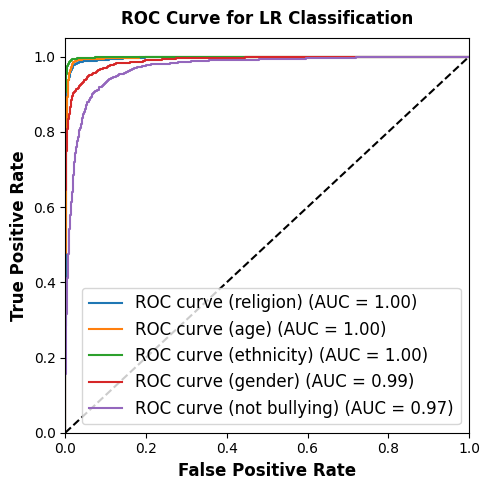

In [204]:
list_of_evaluations.append(evaluate_classification_with_model('LR', lr_clf, X_test_tf, y_test, sentiments))
separate_plotting('LR', lr_clf, X_test_tf, y_test,sentiments)

<a name='3.6'></a>

## Stacking

In [205]:
def get_stacking():
    '''
    Create a stacking classifier
    '''
    level0 = []
    level0.append(('DT', LogisticRegression()))
    level0.append(('SVC', SVC(kernel='sigmoid')))
    level0.append(('NB', MultinomialNB(alpha = 0.5)))
    
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv = 5)
    return model

In [206]:
start_time = time.time()

stacking_model = get_stacking();

stacking_model.fit(X_train_tf, y_train)

end_time = time.time()
runtime['Stacking'] = end_time - start_time


Classification Report for stacking_model:
               precision    recall  f1-score   support

    religion       0.96      0.96      0.96      1568
         age       0.94      0.98      0.96      1552
   ethnicity       0.97      0.98      0.98      1473
      gender       0.94      0.88      0.91      1447
not bullying       0.84      0.85      0.84      1527

    accuracy                           0.93      7567
   macro avg       0.93      0.93      0.93      7567
weighted avg       0.93      0.93      0.93      7567



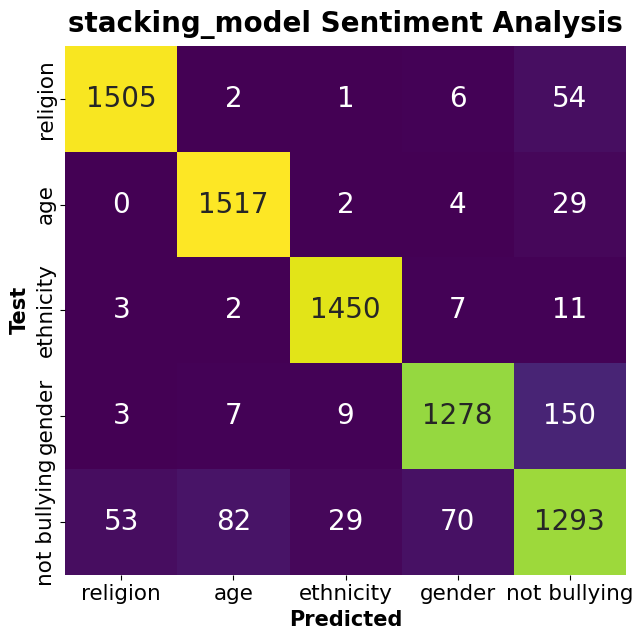

In [207]:
stacking_pred = stacking_model.predict(X_test_tf)

print('Classification Report for stacking_model:\n',classification_report(y_test, stacking_pred, target_names=sentiments))

conf_matrix(y_test,stacking_pred,'stacking_model Sentiment Analysis', sentiments)

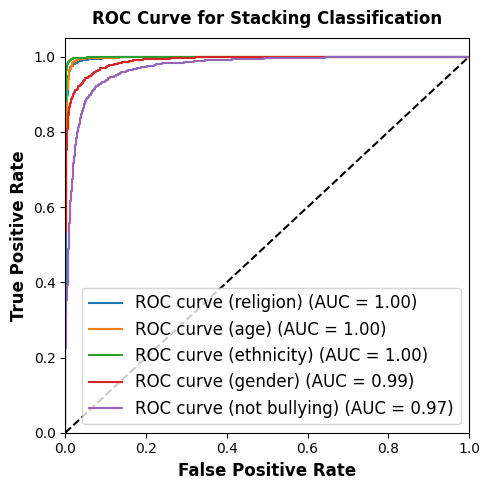

In [208]:
list_of_evaluations.append(evaluate_classification_with_model('Stacking', stacking_model, X_test_tf, y_test,sentiments))
separate_plotting('Stacking', stacking_model, X_test_tf, y_test,sentiments)

<a name='3.6'></a>

## KNN

In [209]:
##testing
#from sklearn.model_selection import GridSearchCV

#param_grid = {'n_neighbors': list(range(1, 31))}  # Try k from 1 to 30
#grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train_tf, y_train)

#print("Best k:", grid_search.best_params_)
#print("Best accuracy:", grid_search.best_score_)


KNN evaluation result: {'Model': 'KNN', 'Accuracy': 0.8601823708206687, 'Precision': 0.8963526251102729, 'Recall': 0.8601823708206687, 'F1': 0.8674372370640824}


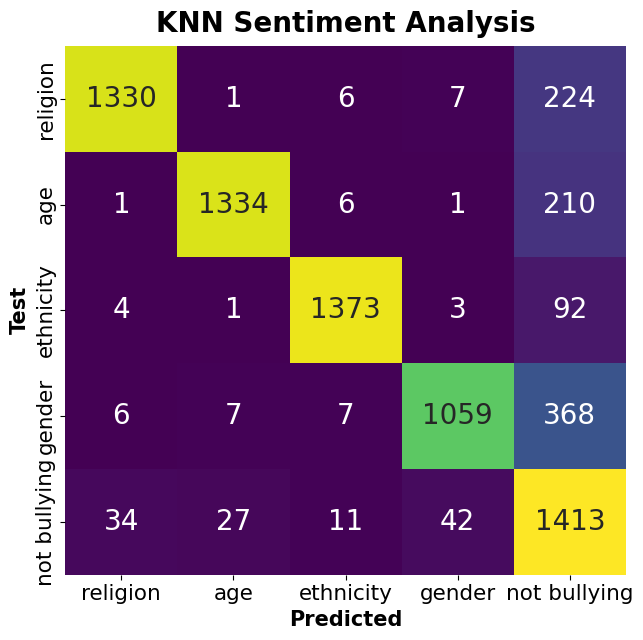

In [210]:
##newKNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
import time

# Preprocessing
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_tf)
X_test_scaled = scaler.transform(X_test_tf)

svd = TruncatedSVD(n_components=100, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_test_svd = svd.transform(X_test_scaled)

# Train KNN
start_time = time.time()
knn_clf = KNeighborsClassifier(n_neighbors=28, weights='distance', metric='minkowski')
knn_clf.fit(X_train_svd, y_train)
end_time = time.time()

# Save runtime
runtime['KNN'] = end_time - start_time

# Evaluate and append results safely
result_knn = evaluate_classification_with_model('KNN', knn_clf, X_test_svd, y_test, sentiments)
print("KNN evaluation result:", result_knn)

required_keys = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1']
if all(k in result_knn for k in required_keys):
    list_of_evaluations.append(result_knn)
else:
    print("⚠ KNN result has missing keys. Skipping.")

# Add this line to fix the error
knn_pred = knn_clf.predict(X_test_svd)

# Now generate confusion matrix
conf_matrix(y_test, knn_pred, 'KNN Sentiment Analysis', sentiments)


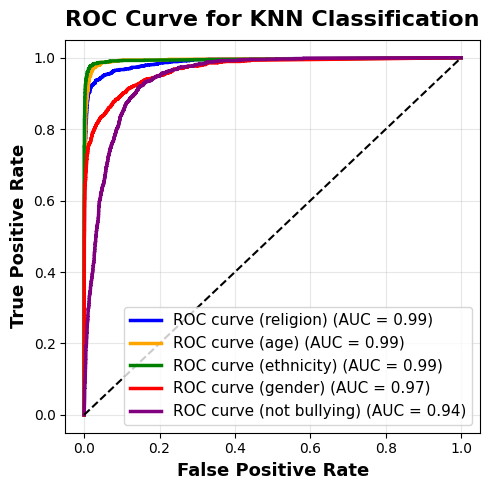

In [211]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# ROC Curve for KNN using the reduced test data
if hasattr(knn_clf, "predict_proba"):
    knn_probs = knn_clf.predict_proba(X_test_svd)  # Use reduced test set!

    # Compute ROC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    colors = ['blue', 'orange', 'green', 'red', 'purple']  # Match with sentiments
    plt.figure(figsize=(5, 5))

    for i in range(len(sentiments)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2.5,
                 label=f'ROC curve ({sentiments[i]}) (AUC = {roc_auc[i]:.2f})')

    # Diagonal for random chance
    plt.plot([0, 1], [0, 1], color='black', linestyle='dashed', lw=1.5)

    # Plot aesthetics
    plt.title('ROC Curve for KNN Classification', fontsize=16, fontweight='bold')
    plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


<a name='3.7'></a>

## Comparing the evaluations of traditional models

In [212]:
evaluation_df = pd.DataFrame(list_of_evaluations)

In [213]:
evaluation_df.set_index('Model', inplace=True)
evaluation_df

Accuracy  Precision    Recall        F1
Model                                            
RF        0.939738   0.942833  0.939738  0.940270
GB        0.933659   0.939372  0.933659  0.934913
NB        0.848156   0.849002  0.848156  0.841125
LR        0.925862   0.927587  0.925862  0.926197
Stacking  0.930752   0.930759  0.930752  0.930532
KNN       0.860182   0.896353  0.860182  0.867437

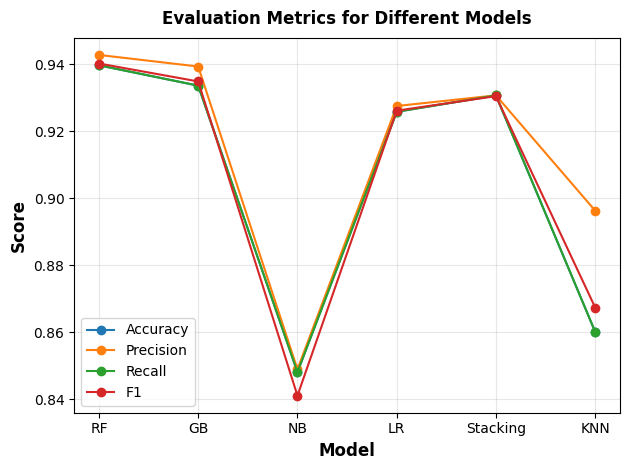

{'RF': 87.09640002250671,
 'GB': 150.79698181152344,
 'NB': 1.755385398864746,
 'LR': 15.440787076950073,
 'Stacking': 341.74328875541687,
 'KNN': 0.005926847457885742}

In [214]:
evaluation_df = pd.DataFrame(list_of_evaluations)

evaluation_df.set_index('Model', inplace=True)
evaluation_df

# Plot all evaluation metrics for all models
for metric in evaluation_df.columns:
    plt.plot(evaluation_df.index, evaluation_df[metric], marker='o', label=metric)

# Customize the plot
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Different Models')
plt.legend()
#plt.xticks(rotation=45)  
plt.grid(True, alpha = 0.3)  
plt.tight_layout() 

#plt.savefig('evaluation_metrics_plot.svg', format='svg')

plt.show()

runtime

<a name='3.7'></a>

## Prediction

In [ ]:
def predict_tweet_sentiment(model, vectorizer, transformer, tweet, sentiments):
    # Step 1: Convert tweet to count vector
    tweet_counts = vectorizer.transform([tweet])

    # Step 2: Apply TF-IDF transformation
    tweet_tfidf = transformer.transform(tweet_counts)

    # Step 3: Predict class
    predicted_label = model.predict(tweet_tfidf)[0]

    # Step 4: Map numeric label to class name
    label_name = sentiments[int(predicted_label)]  # make sure index is int

    print(f"\nTweet: \"{tweet}\"\nPredicted Label: {label_name}")
    return label_name


# Example usage:
sample_tweet = "I will bully you"
predict_tweet_sentiment(rf_clf, clf, tf_transformer, sample_tweet, sentiments)
